# Project ARI3129 - Object Detection & Localisation using Yolov8 *(Jupyter Notebook #2)*
---

**Name:** Andrea Filiberto Lucas  
**ID No:** 0279704L

---

## Automated Dataset Management with Roboflow and Folder Organization

This script automates the process of managing a dataset using Roboflow. It creates necessary directories, checks for installed dependencies, installs them if missing, and downloads the dataset. It also organizes the dataset into a structured folder hierarchy, ensuring everything is ready for further use.

In [2]:
import os
import subprocess
import shutil

# Constants for colored output
COLORS = {
    "green": "\033[92m",  # Green text
    "red": "\033[91m",    # Red text
    "reset": "\033[0m"    # Reset to default color
}

# Define the path to the Versions folder and the target subfolder
versions_path = os.path.abspath(os.path.join("..", "Versions"))
target_subfolder = os.path.join(versions_path, "MDD-AFL-Yolov8")

# Check if the Versions folder exists, if not, create it
if not os.path.exists(versions_path):
    os.makedirs(versions_path)
    print(f"[{COLORS['green']}✔{COLORS['reset']}] Folder created at: {versions_path}")

# Check if the MDD-AFL-Yolov8 subfolder exists
if os.path.exists(target_subfolder):
    print(f"[{COLORS['green']}✔{COLORS['reset']}] The subfolder '{target_subfolder}' already exists. Skipping download!")
else:
    # Check if roboflow is installed
    if importlib.util.find_spec("roboflow") is not None:                                                                                                        # type: ignore
        print(f"[{COLORS['green']}✔{COLORS['reset']}] Roboflow is already installed!")
    else:
        # Install roboflow using pip
        try:
            subprocess.check_call(["pip", "install", "roboflow"])
            print(f"[{COLORS['green']}✔{COLORS['reset']}] Roboflow successfully installed!")
        except subprocess.CalledProcessError as e:
            print(f"[{COLORS['red']}✖{COLORS['reset']}]Failed to install Roboflow. Please check your setup.")
            raise e

    # Import and use Roboflow
    from roboflow import Roboflow                                                                                                                               # type: ignore

    # Prompt the user for their API key
    print("Please enter your Roboflow API key to download the dataset...")
    api_key = input("Please enter your Roboflow API key: ")

    # Initialize Roboflow with the provided API key
    rf = Roboflow(api_key=api_key)

    # Retrieve project and version
    project = rf.workspace("advanced-cv").project("maltese-domestic-dataset")
    version = project.version(1)

    # Download the dataset
    dataset = version.download("yolov8")

    current_folder = os.getcwd()  # Get the current working directory
    original_folder = os.path.join(current_folder, "Maltese-Domestic-Dataset--1")
    renamed_folder = os.path.join(current_folder, "MDD-AFL-Yolov8")
    target_folder = os.path.join(versions_path, "MDD-AFL-Yolov8")

    # Check if the original folder exists
    if os.path.exists(original_folder):
        # Rename the folder
        os.rename(original_folder, renamed_folder)

        # Move the renamed folder to ../Versions/
        shutil.move(renamed_folder, target_folder)
        print(f"[{COLORS['green']}✔{COLORS['reset']}] Folder downloaded to: {target_folder}")
    else:
        print(f"[{COLORS['red']}✖{COLORS['reset']}]Folder '{original_folder}' does not exist. No action taken.")

[✔] The subfolder '/Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8' already exists. Skipping download!


## Automated Library Installer in Python

This script automates checking and installing libraries from a JSON file. It verifies installations, installs missing libraries via `pip`, and provides clear, colored output for success or errors. With built-in error handling and preloaded common libraries, it simplifies dependency management in Python projects.

In [3]:
import json
import importlib.util

# Path to the JSON file
lib_file_path = os.path.join("..", "Libraries", "Task2_AFL_Lib.json")

# Read the libraries from the JSON file
try:
    with open(lib_file_path, 'r') as file:
        libraries = json.load(file)
except FileNotFoundError:
    print(f"{COLORS['red']}Error: Library file not found at {lib_file_path}{COLORS['reset']}")
    exit(1)
except json.JSONDecodeError:
    print(f"{COLORS['red']}Error: Failed to decode JSON from the library file.{COLORS['reset']}")
    exit(1)

# Function to check and install libraries
def check_and_install_libraries(libraries):
    for lib, import_name in libraries.items():
        # Check if the library is installed by checking its module spec
        if importlib.util.find_spec(import_name) is not None:
            print(f"[{COLORS['green']}✔{COLORS['reset']}] Library '{lib}' is already installed.")
        else:
            # If the library is not found, try to install it
            print(f"[{COLORS['red']}✖{COLORS['reset']}] Library '{lib}' is not installed. Installing...")
            try:
                subprocess.check_call(["pip", "install", lib])
                print(f"[{COLORS['green']}✔{COLORS['reset']}] Successfully installed '{lib}'.")
            except subprocess.CalledProcessError:
                print(f"[{COLORS['red']}✖{COLORS['reset']}] Failed to install '{lib}'. Please install it manually.")


# Execute the function to check and install libraries
check_and_install_libraries(libraries)

# Import necessary libraries 
import time
import torch
import random
import cv2                                                                                                                                                      #type: ignore
import matplotlib.pyplot as plt                                                                                                                                 #type: ignore
import seaborn as sns                                                                                                                                           #type: ignore
import numpy as np                                                                                                                                              #type: ignore
import matplotlib.patches as patches                                                                                                                            #type: ignore
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm                                                                                                                                           #type: ignore
from ultralytics import YOLO                                                                                                                                    #type: ignore
from IPython.display import Image, display

[✔] Library 'opencv-python' is already installed.
[✔] Library 'matplotlib' is already installed.
[✔] Library 'tqdm' is already installed.
[✔] Library 'ultralytics' is already installed.
[✔] Library 'torch' is already installed.


## Determine the Available Device for Computation

This function identifies and selects the best available device for running deep learning models, prioritizing hardware acceleration via CUDA (GPU) or MPS (Metal Performance Shaders). If no hardware acceleration is available, it defaults to the CPU and notifies the user.

In [4]:
# Determine the available device: CUDA, MPS, or CPU.
def determine_device():
    if torch.cuda.is_available():
        device = "cuda"
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    elif torch.backends.mps.is_available():
        device = "mps"
        print("Using MPS (Metal Performance Shaders) for acceleration.")
    else:
        device = "cpu"
        print("Using CPU. Consider enabling GPU or MPS for faster training.")
    return device

## Training process for Yolov8 object detector.
### Experiment Configuration for YOLOv8

Defines the path to the `data.yaml` file and key hyperparameters for conducting experiments with YOLOv8. These settings include the number of epochs, image size, batch size, and a customizable experiment name for version tracking and organization.

In [5]:
# Path to data.yaml
data_yaml_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "Versions", "MDD-AFL-Yolov8", "data.yaml")

# Hyperparameters - To Change for different experiments
epochs = 100
imgsz = 640
batch_size = 8
experiment_name = "MDD-AFL-Yolov8_v3"

### YOLOv8 Training and Validation Pipeline

This script initializes and trains a YOLOv8 model from scratch using a specified architecture (`yolov8s.yaml`, `yolov8n.yaml`). Key features include:
- **Timer**: Measures and reports total training time in hours, minutes, and seconds.
- **Training**: Configurable hyperparameters for epochs, image size, batch size, and experiment naming.
- **Quick Validation**: Evaluates the model on a dataset and saves validation metrics as a JSON file for later analysis.

Error handling is incorporated for key stages, including model creation, training, and validation, ensuring robustness in experimentation workflows.

In [6]:
# Timer start
start_time = time.time()

# Create or load a YOLOv8 model (from scratch)
try:
    model = YOLO("yolov8s.yaml")  # specify architecture
except FileNotFoundError:
    print("Error: YOLOv8 configuration file 'yolov8s.yaml' not found. Check your setup.")
    raise

# Train
try:
    model.train(
        data=data_yaml_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch_size,
        name=experiment_name,
        pretrained=False,  
    )
except Exception as e:
    print(f"Error during training: {e}")
    raise

# Timer end
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time
# Convert seconds to hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)
print(f"Training completed in {hours}h {minutes}m {seconds}s.")

# Evaluate
try:
    metrics = model.val()
    print("Validation Metrics:", metrics)
except Exception as e:
    print(f"Error during validation: {e}")
    raise

New https://pypi.org/project/ultralytics/8.3.59 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.58 🚀 Python-3.11.1 torch-2.3.1 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/data.yaml, epochs=55, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=MDD-AFL-Yolov8_v2, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, 

train: Scanning /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/train/labels.cache... 748 images, 0 backgrounds, 0 corrupt: 100%|██████████| 748/748 [00:00<?, ?it/s]
val: Scanning /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/valid/labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]

Plotting labels to runs/detect/MDD-AFL-Yolov8_v2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/MDD-AFL-Yolov8_v2
Starting training for 55 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/55         0G       3.48      4.368      4.167         29        640: 100%|██████████| 94/94 [14:21<00:00,  9.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:49<00:00,  9.81s/it]

                   all         70        228    0.00104      0.158    0.00195   0.000425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/55         0G      3.263      3.962      3.794         28        640: 100%|██████████| 94/94 [12:38<00:00,  8.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:51<00:00, 10.24s/it]

                   all         70        228      0.516     0.0758    0.00846    0.00234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/55         0G      3.025      3.714       3.43         11        640: 100%|██████████| 94/94 [13:21<00:00,  8.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:52<00:00, 10.45s/it]

                   all         70        228      0.513      0.071     0.0137    0.00408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/55         0G      2.882      3.614      3.203         63        640: 100%|██████████| 94/94 [13:54<00:00,  8.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:56<00:00, 11.27s/it]

                   all         70        228      0.392     0.0906     0.0576     0.0185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/55         0G      2.779      3.445      3.035         31        640: 100%|██████████| 94/94 [13:39<00:00,  8.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.70s/it]

                   all         70        228      0.636      0.146      0.112     0.0337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/55         0G      2.638      3.359      2.957         13        640: 100%|██████████| 94/94 [13:57<00:00,  8.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<00:00, 10.71s/it]

                   all         70        228      0.788      0.024     0.0237    0.00837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/55         0G      2.587      3.293      2.881         20        640: 100%|██████████| 94/94 [12:58<00:00,  8.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.13s/it]

                   all         70        228       0.41      0.177      0.117     0.0444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/55         0G      2.443       3.04      2.758         33        640: 100%|██████████| 94/94 [12:46<00:00,  8.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.73s/it]

                   all         70        228      0.627      0.158      0.128     0.0478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/55         0G       2.37       2.96       2.69         21        640: 100%|██████████| 94/94 [13:32<00:00,  8.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.70s/it]

                   all         70        228      0.489      0.234      0.191     0.0773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/55         0G      2.259      2.899      2.631         13        640: 100%|██████████| 94/94 [13:39<00:00,  8.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.78s/it]

                   all         70        228      0.437       0.28      0.191      0.079



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/55         0G      2.278      2.854      2.615         41        640: 100%|██████████| 94/94 [13:52<00:00,  8.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:49<00:00,  9.81s/it]

                   all         70        228      0.609      0.205      0.204     0.0962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/55         0G      2.165      2.731      2.526         21        640: 100%|██████████| 94/94 [13:45<00:00,  8.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.72s/it]

                   all         70        228      0.511        0.3      0.282      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/55         0G      2.105      2.656      2.468         21        640: 100%|██████████| 94/94 [12:06<00:00,  7.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.06s/it]

                   all         70        228      0.511      0.297      0.245      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/55         0G      2.088      2.656      2.454         31        640: 100%|██████████| 94/94 [12:09<00:00,  7.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.10s/it]

                   all         70        228       0.55      0.262      0.248      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/55         0G      2.077      2.584      2.408         12        640: 100%|██████████| 94/94 [12:04<00:00,  7.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.93s/it]

                   all         70        228       0.39      0.317      0.271      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/55         0G      1.988      2.478      2.348         45        640: 100%|██████████| 94/94 [11:54<00:00,  7.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.12s/it]

                   all         70        228      0.393      0.289      0.251       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/55         0G      1.956      2.423      2.312         29        640: 100%|██████████| 94/94 [12:03<00:00,  7.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.87s/it]

                   all         70        228      0.532      0.305       0.29      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/55         0G      1.919      2.372      2.294         19        640: 100%|██████████| 94/94 [11:51<00:00,  7.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.90s/it]

                   all         70        228      0.612      0.275      0.285      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/55         0G      1.898      2.381      2.273         26        640: 100%|██████████| 94/94 [12:14<00:00,  7.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.90s/it]

                   all         70        228      0.361      0.445      0.316      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/55         0G      1.883      2.323      2.249         24        640: 100%|██████████| 94/94 [11:49<00:00,  7.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.84s/it]

                   all         70        228      0.392      0.363        0.3      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/55         0G      1.885       2.33      2.242         28        640: 100%|██████████| 94/94 [11:52<00:00,  7.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.92s/it]

                   all         70        228      0.503      0.369      0.342      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/55         0G      1.827       2.24      2.183         18        640: 100%|██████████| 94/94 [12:12<00:00,  7.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.92s/it]

                   all         70        228      0.406      0.409      0.327      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/55         0G      1.807       2.24        2.2          4        640: 100%|██████████| 94/94 [12:10<00:00,  7.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:49<00:00,  9.83s/it]

                   all         70        228      0.615      0.393      0.365      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/55         0G      1.824      2.227      2.174         22        640: 100%|██████████| 94/94 [13:33<00:00,  8.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.77s/it]

                   all         70        228      0.513      0.441      0.378      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/55         0G      1.816       2.15      2.167         42        640: 100%|██████████| 94/94 [13:38<00:00,  8.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.66s/it]

                   all         70        228      0.613      0.404      0.366      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/55         0G      1.803      2.134       2.13         26        640: 100%|██████████| 94/94 [13:43<00:00,  8.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.71s/it]

                   all         70        228      0.443        0.4      0.379      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/55         0G       1.73      2.093      2.082         38        640: 100%|██████████| 94/94 [13:42<00:00,  8.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.60s/it]

                   all         70        228       0.54      0.453      0.426      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/55         0G      1.741      2.032      2.096         43        640: 100%|██████████| 94/94 [12:17<00:00,  7.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.86s/it]

                   all         70        228      0.568      0.408      0.393      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/55         0G      1.742      2.066      2.082         41        640: 100%|██████████| 94/94 [11:54<00:00,  7.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.97s/it]

                   all         70        228       0.48      0.463       0.43      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/55         0G      1.732      2.024      2.077         15        640: 100%|██████████| 94/94 [12:02<00:00,  7.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.83s/it]

                   all         70        228      0.598      0.387      0.415      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/55         0G      1.737       2.06      2.063         15        640: 100%|██████████| 94/94 [12:03<00:00,  7.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.86s/it]

                   all         70        228        0.5      0.436      0.428      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/55         0G      1.683      1.962      2.049         26        640: 100%|██████████| 94/94 [11:54<00:00,  7.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.89s/it]

                   all         70        228      0.527      0.459       0.45      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/55         0G       1.69      2.014      2.041         13        640: 100%|██████████| 94/94 [11:56<00:00,  7.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.32s/it]

                   all         70        228      0.661      0.362      0.447      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/55         0G      1.651      1.937      2.014         21        640: 100%|██████████| 94/94 [13:45<00:00,  8.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.63s/it]

                   all         70        228      0.515      0.467      0.448      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/55         0G      1.671        1.9      2.015         29        640: 100%|██████████| 94/94 [13:48<00:00,  8.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.67s/it]

                   all         70        228      0.579      0.459      0.459      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/55         0G      1.675      1.933      2.017         38        640: 100%|██████████| 94/94 [13:46<00:00,  8.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.73s/it]

                   all         70        228      0.449      0.458      0.435       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/55         0G      1.632      1.874      1.955         31        640: 100%|██████████| 94/94 [13:46<00:00,  8.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.75s/it]

                   all         70        228      0.526      0.501      0.441      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/55         0G      1.643      1.869      1.976         12        640: 100%|██████████| 94/94 [15:19<00:00,  9.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [02:04<00:00, 24.89s/it]

                   all         70        228      0.602      0.465      0.481      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/55         0G      1.591      1.782      1.946         28        640: 100%|██████████| 94/94 [38:27<00:00, 24.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [02:02<00:00, 24.45s/it]

                   all         70        228      0.779      0.436      0.501      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/55         0G      1.594      1.809      1.948         17        640: 100%|██████████| 94/94 [39:42<00:00, 25.34s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [02:03<00:00, 24.68s/it]

                   all         70        228      0.624      0.426      0.473      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/55         0G       1.57      1.811      1.938         35        640: 100%|██████████| 94/94 [19:53<00:00, 12.70s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:52<00:00, 10.41s/it]

                   all         70        228      0.574      0.495      0.495      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/55         0G      1.549      1.733      1.921         21        640: 100%|██████████| 94/94 [14:36<00:00,  9.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:52<00:00, 10.48s/it]

                   all         70        228      0.533      0.471      0.475      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/55         0G      1.561       1.78      1.924         31        640: 100%|██████████| 94/94 [15:22<00:00,  9.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:52<00:00, 10.56s/it]

                   all         70        228      0.494      0.517      0.494      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/55         0G      1.537       1.73        1.9         47        640: 100%|██████████| 94/94 [14:48<00:00,  9.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:52<00:00, 10.44s/it]

                   all         70        228      0.527      0.511      0.508      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/55         0G      1.555       1.71      1.906         15        640: 100%|██████████| 94/94 [15:59<00:00, 10.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:53<00:00, 10.77s/it]

                   all         70        228      0.554      0.532      0.522      0.309


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/55         0G      1.454      1.632      1.849         25        640: 100%|██████████| 94/94 [15:49<00:00, 10.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.45s/it]

                   all         70        228      0.549      0.478      0.509      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/55         0G      1.406      1.563      1.828         12        640: 100%|██████████| 94/94 [14:05<00:00,  8.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.50s/it]

                   all         70        228      0.555      0.497        0.5      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/55         0G      1.404      1.538      1.818         28        640: 100%|██████████| 94/94 [15:18<00:00,  9.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:55<00:00, 11.13s/it]

                   all         70        228      0.523      0.512      0.524      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/55         0G      1.373      1.482      1.783         10        640: 100%|██████████| 94/94 [16:03<00:00, 10.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:51<00:00, 10.33s/it]

                   all         70        228      0.668      0.492      0.548      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/55         0G      1.376      1.477      1.786         16        640: 100%|██████████| 94/94 [15:51<00:00, 10.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:52<00:00, 10.52s/it]

                   all         70        228      0.748      0.454      0.536      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/55         0G      1.354      1.413      1.779         13        640: 100%|██████████| 94/94 [15:19<00:00,  9.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:51<00:00, 10.27s/it]

                   all         70        228      0.576      0.478      0.533       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/55         0G      1.336      1.404      1.737          5        640: 100%|██████████| 94/94 [15:19<00:00,  9.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:50<00:00, 10.16s/it]

                   all         70        228      0.619      0.507      0.544      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/55         0G      1.318      1.356       1.73          9        640: 100%|██████████| 94/94 [14:47<00:00,  9.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.53s/it]

                   all         70        228      0.682       0.47      0.563      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/55         0G      1.314      1.363      1.733         13        640: 100%|██████████| 94/94 [13:09<00:00,  8.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:58<00:00, 11.73s/it]

                   all         70        228      0.737      0.459      0.555      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/55         0G       1.29      1.368      1.717          8        640: 100%|██████████| 94/94 [13:15<00:00,  8.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.37s/it]

                   all         70        228      0.582      0.537       0.56      0.348



55 epochs completed in 14.163 hours.
Optimizer stripped from runs/detect/MDD-AFL-Yolov8_v2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/MDD-AFL-Yolov8_v2/weights/best.pt, 22.5MB

Validating runs/detect/MDD-AFL-Yolov8_v2/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.1 torch-2.3.1 CPU (Apple M2)
YOLOv8s summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:50<00:00, 10.03s/it]


                   all         70        228      0.672      0.477      0.563      0.354
           Mixed Waste         20         67      0.756      0.537      0.593      0.361
         Organic Waste         26         53      0.847      0.419      0.682      0.437
           Other Waste         23         56      0.444      0.143       0.18     0.0959
   Recyclable Material         25         52      0.642      0.808      0.798      0.521
Speed: 3.6ms preprocess, 696.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/MDD-AFL-Yolov8_v2
Training completed in 51046.19 seconds.
Ultralytics 8.3.58 🚀 Python-3.11.1 torch-2.3.1 CPU (Apple M2)
YOLOv8s summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/valid/labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:33<00:00,  3.70s/it]


                   all         70        228      0.672      0.477      0.563      0.354
           Mixed Waste         20         67      0.756      0.537      0.593      0.361
         Organic Waste         26         53      0.847      0.419      0.682      0.437
           Other Waste         23         56      0.444      0.143       0.18     0.0959
   Recyclable Material         25         52      0.642      0.808      0.798      0.521
Speed: 3.4ms preprocess, 460.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/MDD-AFL-Yolov8_v22
Validation Metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x334acc110>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.0030

TypeError: Object of type DetMetrics is not JSON serializable

In [9]:
# Path to data.yaml (relative to Yolov8_AFL.ipynb)
data_yaml_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "Versions", "MDD-AFL-Yolov8", "data.yaml")

# Create or load a YOLOv8 model (from scratch)
model = YOLO("yolov8n.yaml")  # specify your chosen architecture (e.g., yolov8n.yaml)

# Train
model.train(
    data=data_yaml_path,
    epochs=50,
    imgsz=640,
    batch=8,
    name="MDD-AFL-Yolov8_v1",
    pretrained=False  # to train from scratch
)

# Evaluate
metrics = model.val()
print("Validation Metrics:", metrics)

Ultralytics 8.3.58 🚀 Python-3.11.1 torch-2.3.1 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=MDD-AFL-Yolov8_v1, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save

train: Scanning /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/train/labels... 748 images, 0 backgrounds, 0 corrupt: 100%|██████████| 748/748 [00:21<00:00, 35.01it/s]  

train: New cache created: /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/train/labels.cache



val: Scanning /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/valid/labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:17<00:00,  3.89it/s]

val: New cache created: /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/valid/labels.cache


Plotting labels to runs/detect/MDD-AFL-Yolov8_v1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/MDD-AFL-Yolov8_v1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      3.485      4.524       4.19         29        640: 100%|██████████| 94/94 [06:41<00:00,  4.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.90s/it]

                   all         70        228   0.000499     0.0507   0.000319   9.31e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      3.311      4.191      3.864         28        640: 100%|██████████| 94/94 [07:15<00:00,  4.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:25<00:00,  5.05s/it]

                   all         70        228      0.257     0.0915    0.00318    0.00089



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      3.214      3.904      3.506         11        640: 100%|██████████| 94/94 [07:21<00:00,  4.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<00:00,  5.54s/it]

                   all         70        228     0.0165      0.177    0.00831    0.00283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G       3.09      3.854        3.3         63        640: 100%|██████████| 94/94 [07:09<00:00,  4.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:31<00:00,  6.37s/it]

                   all         70        228     0.0177      0.098     0.0129    0.00332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.962      3.616      3.107         31        640: 100%|██████████| 94/94 [07:06<00:00,  4.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:28<00:00,  5.60s/it]

                   all         70        228      0.172     0.0926     0.0694     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      2.747      3.517      2.953         13        640: 100%|██████████| 94/94 [07:21<00:00,  4.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:30<00:00,  6.19s/it]

                   all         70        228      0.458      0.134     0.0905     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      2.659      3.356      2.849         20        640: 100%|██████████| 94/94 [07:04<00:00,  4.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.83s/it]

                   all         70        228      0.341      0.174     0.0983     0.0314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      2.543      3.137      2.756         33        640: 100%|██████████| 94/94 [06:04<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.79s/it]

                   all         70        228      0.347      0.236      0.106      0.037



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      2.401      3.063      2.651         21        640: 100%|██████████| 94/94 [06:35<00:00,  4.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.72s/it]

                   all         70        228      0.239      0.168      0.137     0.0484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      2.285      2.983      2.569         13        640: 100%|██████████| 94/94 [06:31<00:00,  4.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.87s/it]

                   all         70        228      0.398      0.263      0.174     0.0727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      2.266      2.922       2.54         41        640: 100%|██████████| 94/94 [06:44<00:00,  4.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.69s/it]

                   all         70        228      0.509       0.23      0.178     0.0754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      2.157      2.786      2.458         21        640: 100%|██████████| 94/94 [05:48<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.60s/it]

                   all         70        228      0.583      0.236      0.233     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      2.154      2.714      2.413         21        640: 100%|██████████| 94/94 [06:01<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.87s/it]

                   all         70        228      0.615      0.264      0.238      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      2.125      2.742      2.404         31        640: 100%|██████████| 94/94 [05:49<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.87s/it]

                   all         70        228      0.515      0.248      0.222      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      2.101      2.643      2.335         12        640: 100%|██████████| 94/94 [05:48<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.78s/it]

                   all         70        228      0.425      0.334      0.252      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      2.015      2.541      2.287         45        640: 100%|██████████| 94/94 [05:49<00:00,  3.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.71s/it]

                   all         70        228      0.249       0.33      0.215      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      2.006      2.507      2.263         29        640: 100%|██████████| 94/94 [05:49<00:00,  3.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.62s/it]

                   all         70        228      0.459      0.357      0.338      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.963      2.459      2.241         19        640: 100%|██████████| 94/94 [05:50<00:00,  3.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.65s/it]

                   all         70        228      0.381      0.351      0.269      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.959      2.442      2.222         26        640: 100%|██████████| 94/94 [05:47<00:00,  3.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.61s/it]

                   all         70        228      0.403      0.328      0.256       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.922      2.413      2.189         24        640: 100%|██████████| 94/94 [05:52<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.367      0.289      0.284      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.917      2.377      2.178         28        640: 100%|██████████| 94/94 [05:44<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.405      0.383      0.301      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.894      2.349       2.15         18        640: 100%|██████████| 94/94 [05:43<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.59s/it]

                   all         70        228      0.499      0.362       0.34      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.856      2.316      2.157          4        640: 100%|██████████| 94/94 [05:37<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.53s/it]

                   all         70        228      0.511       0.38      0.317      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G       1.89      2.305      2.148         22        640: 100%|██████████| 94/94 [05:43<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.478      0.358      0.289      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.873      2.266      2.126         42        640: 100%|██████████| 94/94 [06:04<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.672      0.305      0.335      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.864      2.209      2.111         26        640: 100%|██████████| 94/94 [05:45<00:00,  3.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.56s/it]

                   all         70        228      0.521      0.383      0.363      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.798      2.171      2.071         38        640: 100%|██████████| 94/94 [05:47<00:00,  3.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.52s/it]

                   all         70        228      0.513      0.372      0.382      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.794      2.114      2.063         43        640: 100%|██████████| 94/94 [05:39<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.55s/it]

                   all         70        228      0.462      0.417      0.399       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.792      2.135      2.049         41        640: 100%|██████████| 94/94 [05:39<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.52s/it]

                   all         70        228      0.494      0.419      0.369      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G        1.8      2.154      2.063         15        640: 100%|██████████| 94/94 [05:54<00:00,  3.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.628      0.403      0.406      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.791      2.172       2.04         15        640: 100%|██████████| 94/94 [05:44<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.475      0.429      0.392      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.748      2.074      2.034         26        640: 100%|██████████| 94/94 [05:38<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.51s/it]

                   all         70        228      0.515      0.409      0.387      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.755      2.084      2.027         13        640: 100%|██████████| 94/94 [05:42<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.51s/it]

                   all         70        228      0.525      0.428      0.411      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.729      2.047      2.011         21        640: 100%|██████████| 94/94 [05:40<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.55s/it]

                   all         70        228      0.576      0.414      0.414      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.728      1.982      1.993         29        640: 100%|██████████| 94/94 [05:53<00:00,  3.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.51s/it]

                   all         70        228      0.492      0.417      0.401       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.749      2.046      2.014         38        640: 100%|██████████| 94/94 [05:40<00:00,  3.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.64s/it]

                   all         70        228      0.514      0.438      0.434      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.706      1.976      1.958         31        640: 100%|██████████| 94/94 [05:41<00:00,  3.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.75s/it]

                   all         70        228      0.616      0.422      0.431      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.719       1.98      1.974         12        640: 100%|██████████| 94/94 [05:30<00:00,  3.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.55s/it]

                   all         70        228      0.567       0.45      0.429      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.667      1.905      1.939         28        640: 100%|██████████| 94/94 [05:31<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.50s/it]

                   all         70        228      0.619      0.425      0.436       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.694      1.944      1.963         17        640: 100%|██████████| 94/94 [05:43<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.57s/it]

                   all         70        228      0.652      0.379       0.45      0.269


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.591      1.921      1.905          8        640: 100%|██████████| 94/94 [06:26<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.70s/it]

                   all         70        228      0.592      0.369      0.429      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.564      1.813      1.891          8        640: 100%|██████████| 94/94 [05:49<00:00,  3.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.523      0.489      0.459      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.526      1.724      1.859         10        640: 100%|██████████| 94/94 [05:40<00:00,  3.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.555      0.444      0.433      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.531      1.718      1.867         15        640: 100%|██████████| 94/94 [05:40<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228       0.59      0.478      0.472      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.521      1.692      1.849         21        640: 100%|██████████| 94/94 [05:37<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.52s/it]

                   all         70        228      0.662      0.433      0.473      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.488      1.634      1.821         20        640: 100%|██████████| 94/94 [05:39<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.56s/it]

                   all         70        228      0.558      0.497      0.493      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.497      1.658      1.836         11        640: 100%|██████████| 94/94 [05:26<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.616      0.475      0.473      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.511      1.632      1.822         23        640: 100%|██████████| 94/94 [05:36<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.52s/it]

                   all         70        228      0.706      0.434       0.48      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.474      1.617      1.802         10        640: 100%|██████████| 94/94 [05:35<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.56s/it]

                   all         70        228      0.508      0.533      0.487      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.474       1.62      1.819         16        640: 100%|██████████| 94/94 [05:33<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.50s/it]

                   all         70        228       0.49      0.531      0.495      0.303



50 epochs completed in 5.343 hours.
Optimizer stripped from runs/detect/MDD-AFL-Yolov8_v1/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/MDD-AFL-Yolov8_v1/weights/best.pt, 6.3MB

Validating runs/detect/MDD-AFL-Yolov8_v1/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.1 torch-2.3.1 CPU (Apple M2)
YOLOv8n summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.90s/it]


                   all         70        228      0.493      0.534      0.495      0.303
           Mixed Waste         20         67      0.497      0.517      0.514      0.307
         Organic Waste         26         53      0.499      0.585      0.474      0.281
           Other Waste         23         56      0.454      0.149      0.199        0.1
   Recyclable Material         25         52      0.521      0.885      0.794      0.525
Speed: 2.5ms preprocess, 333.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/MDD-AFL-Yolov8_v1
Ultralytics 8.3.58 🚀 Python-3.11.1 torch-2.3.1 CPU (Apple M2)
YOLOv8n summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/valid/labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:14<00:00,  1.60s/it]


                   all         70        228      0.493      0.534      0.495      0.303
           Mixed Waste         20         67      0.497      0.517      0.514      0.307
         Organic Waste         26         53      0.499      0.585      0.474      0.281
           Other Waste         23         56      0.454      0.149      0.199        0.1
   Recyclable Material         25         52      0.521      0.885      0.794      0.525
Speed: 2.3ms preprocess, 191.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/MDD-AFL-Yolov8_v12
Validation Metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x3340edad0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.0030

In [ ]:
# Timer start
start_time = time.time()

# Create or load a YOLOv8 model (from scratch)
try:
    model = YOLO("yolov8n.yaml")  # specify architecture
except FileNotFoundError:
    print("Error: YOLOv8 configuration file 'yolov8n.yaml' not found. Check your setup.")
    raise

# Train
try:
    model.train(
        data=data_yaml_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch_size,
        name=experiment_name,
        pretrained=False
    )
except Exception as e:
    print(f"Error during training: {e}")
    raise

# Timer end
end_time = time.time()
# Calculate elapsed time
elapsed_time = end_time - start_time
# Convert seconds to hours, minutes, and seconds
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)
print(f"Training completed in {hours}h {minutes}m {seconds}s.")

# Evaluate
try:
    metrics = model.val()
    print("Validation Metrics:", metrics)
except Exception as e:
    print(f"Error during validation: {e}")
    raise

Available folders:
1. MDD-AFL-Yolov8_v1R
2. MDD-AFL-Yolov8_v2R


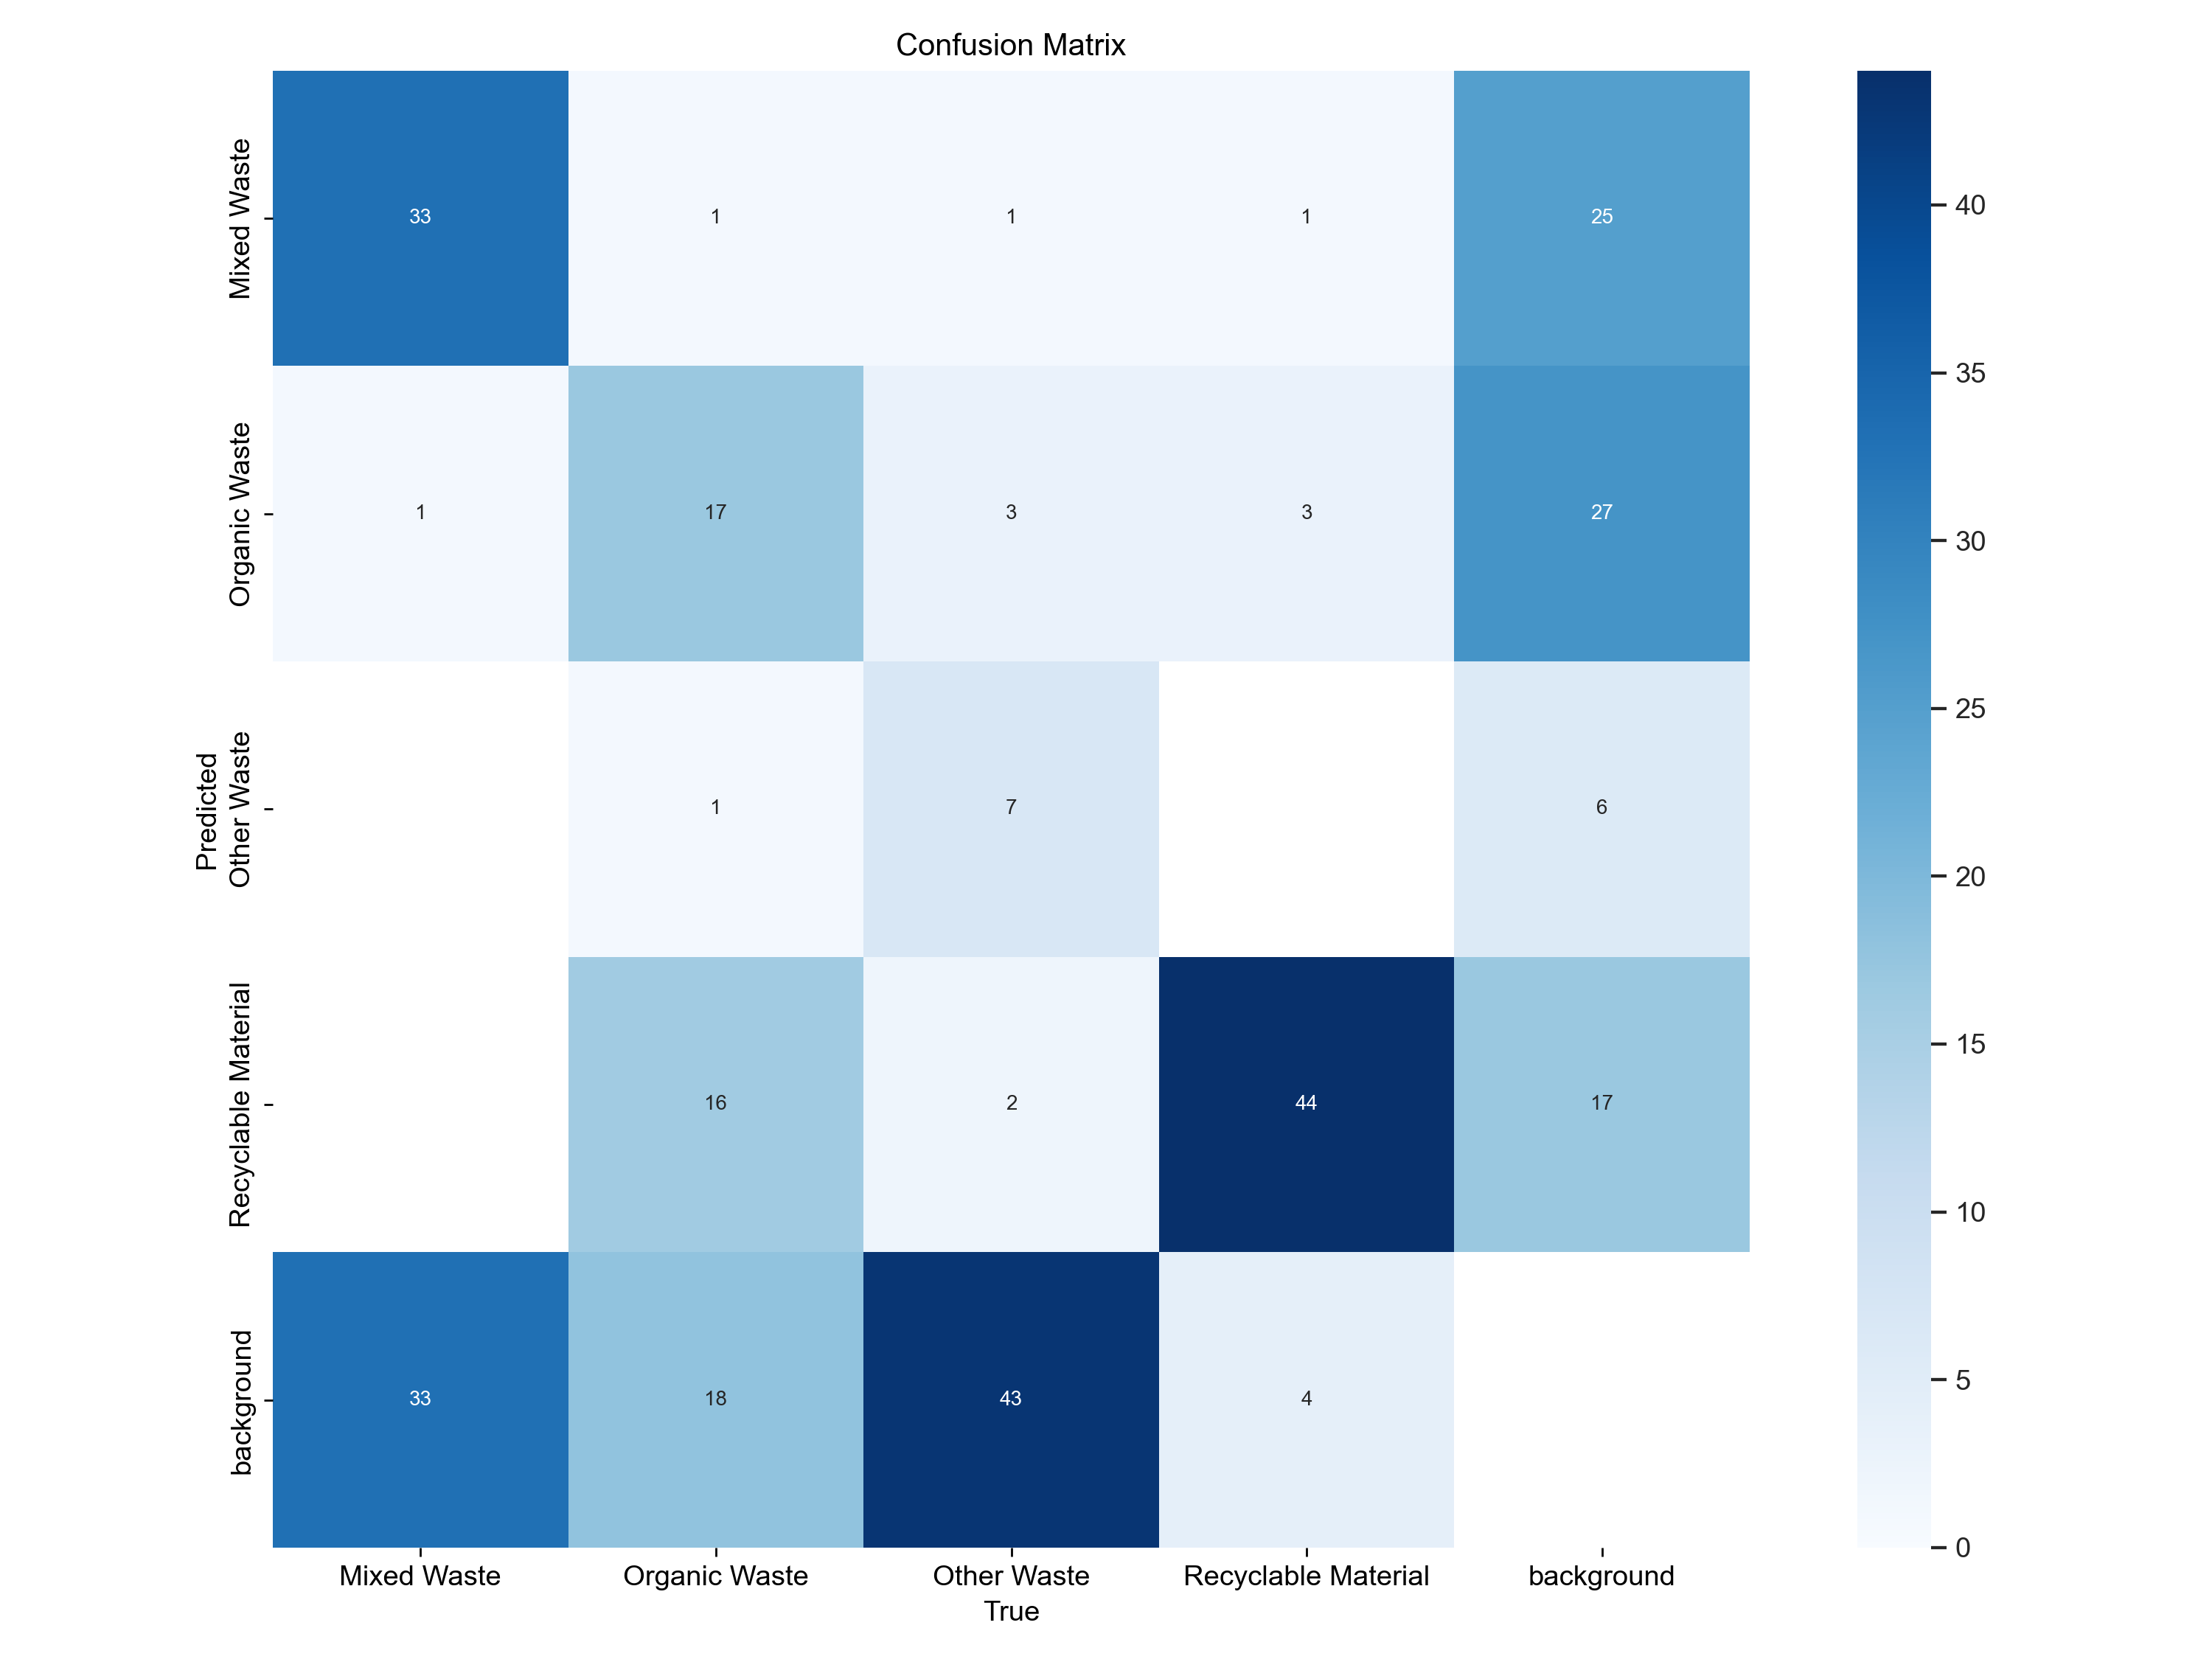

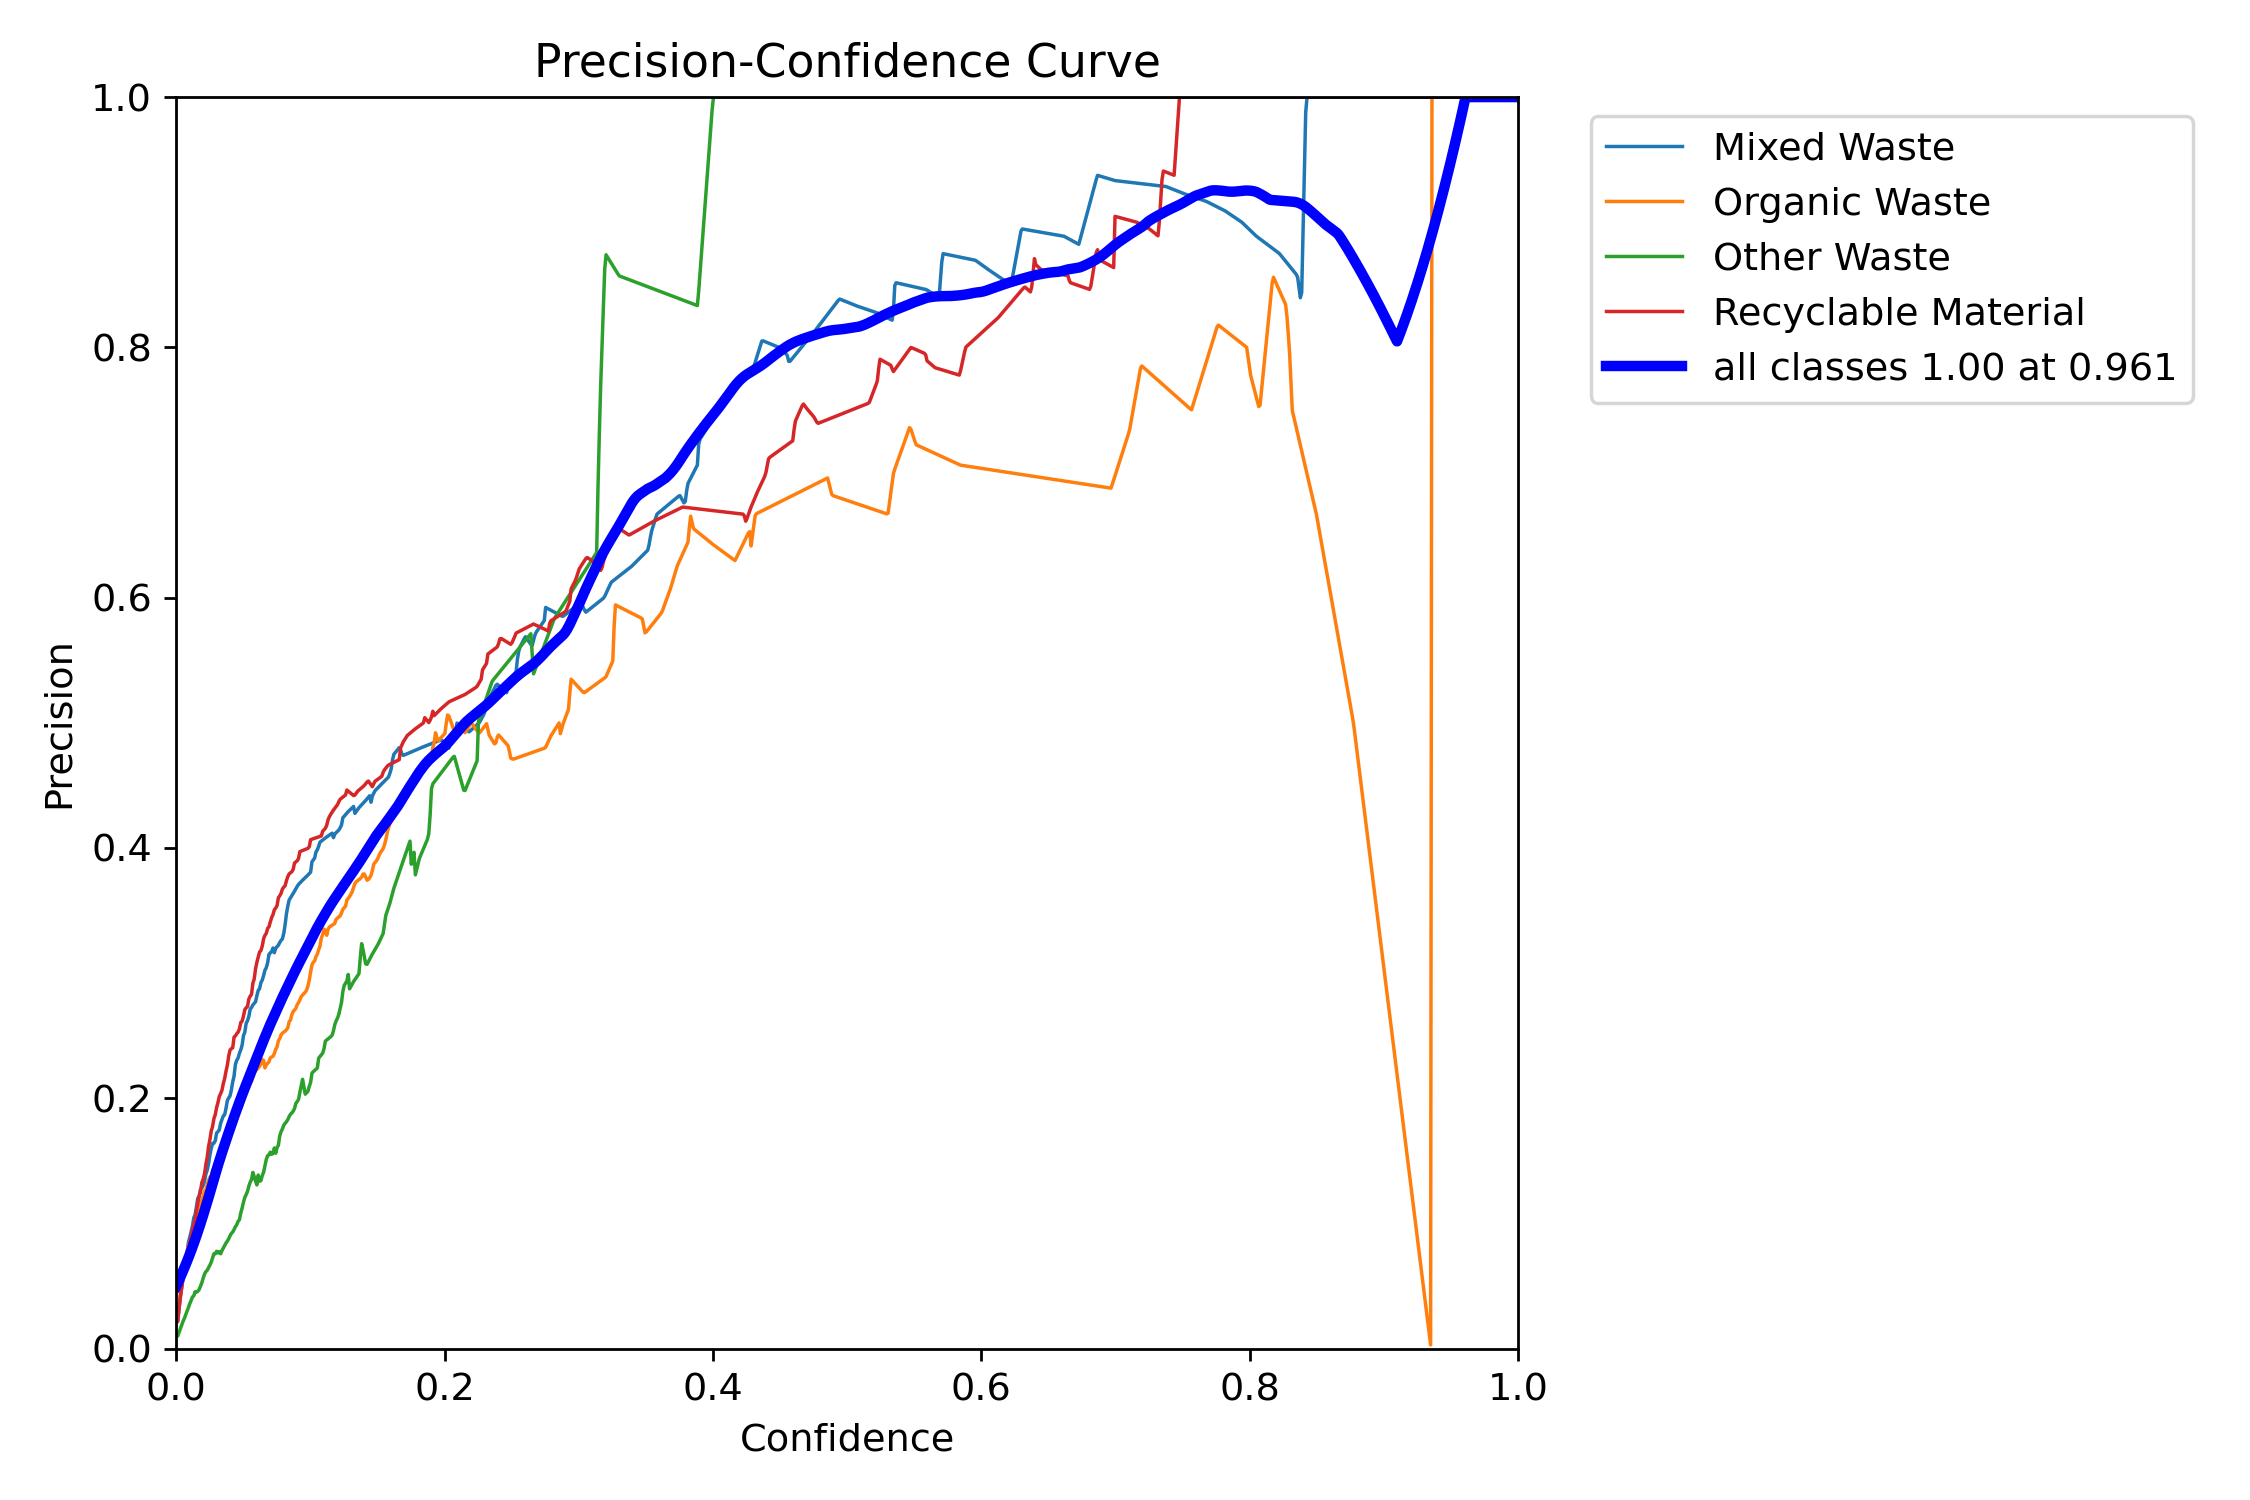

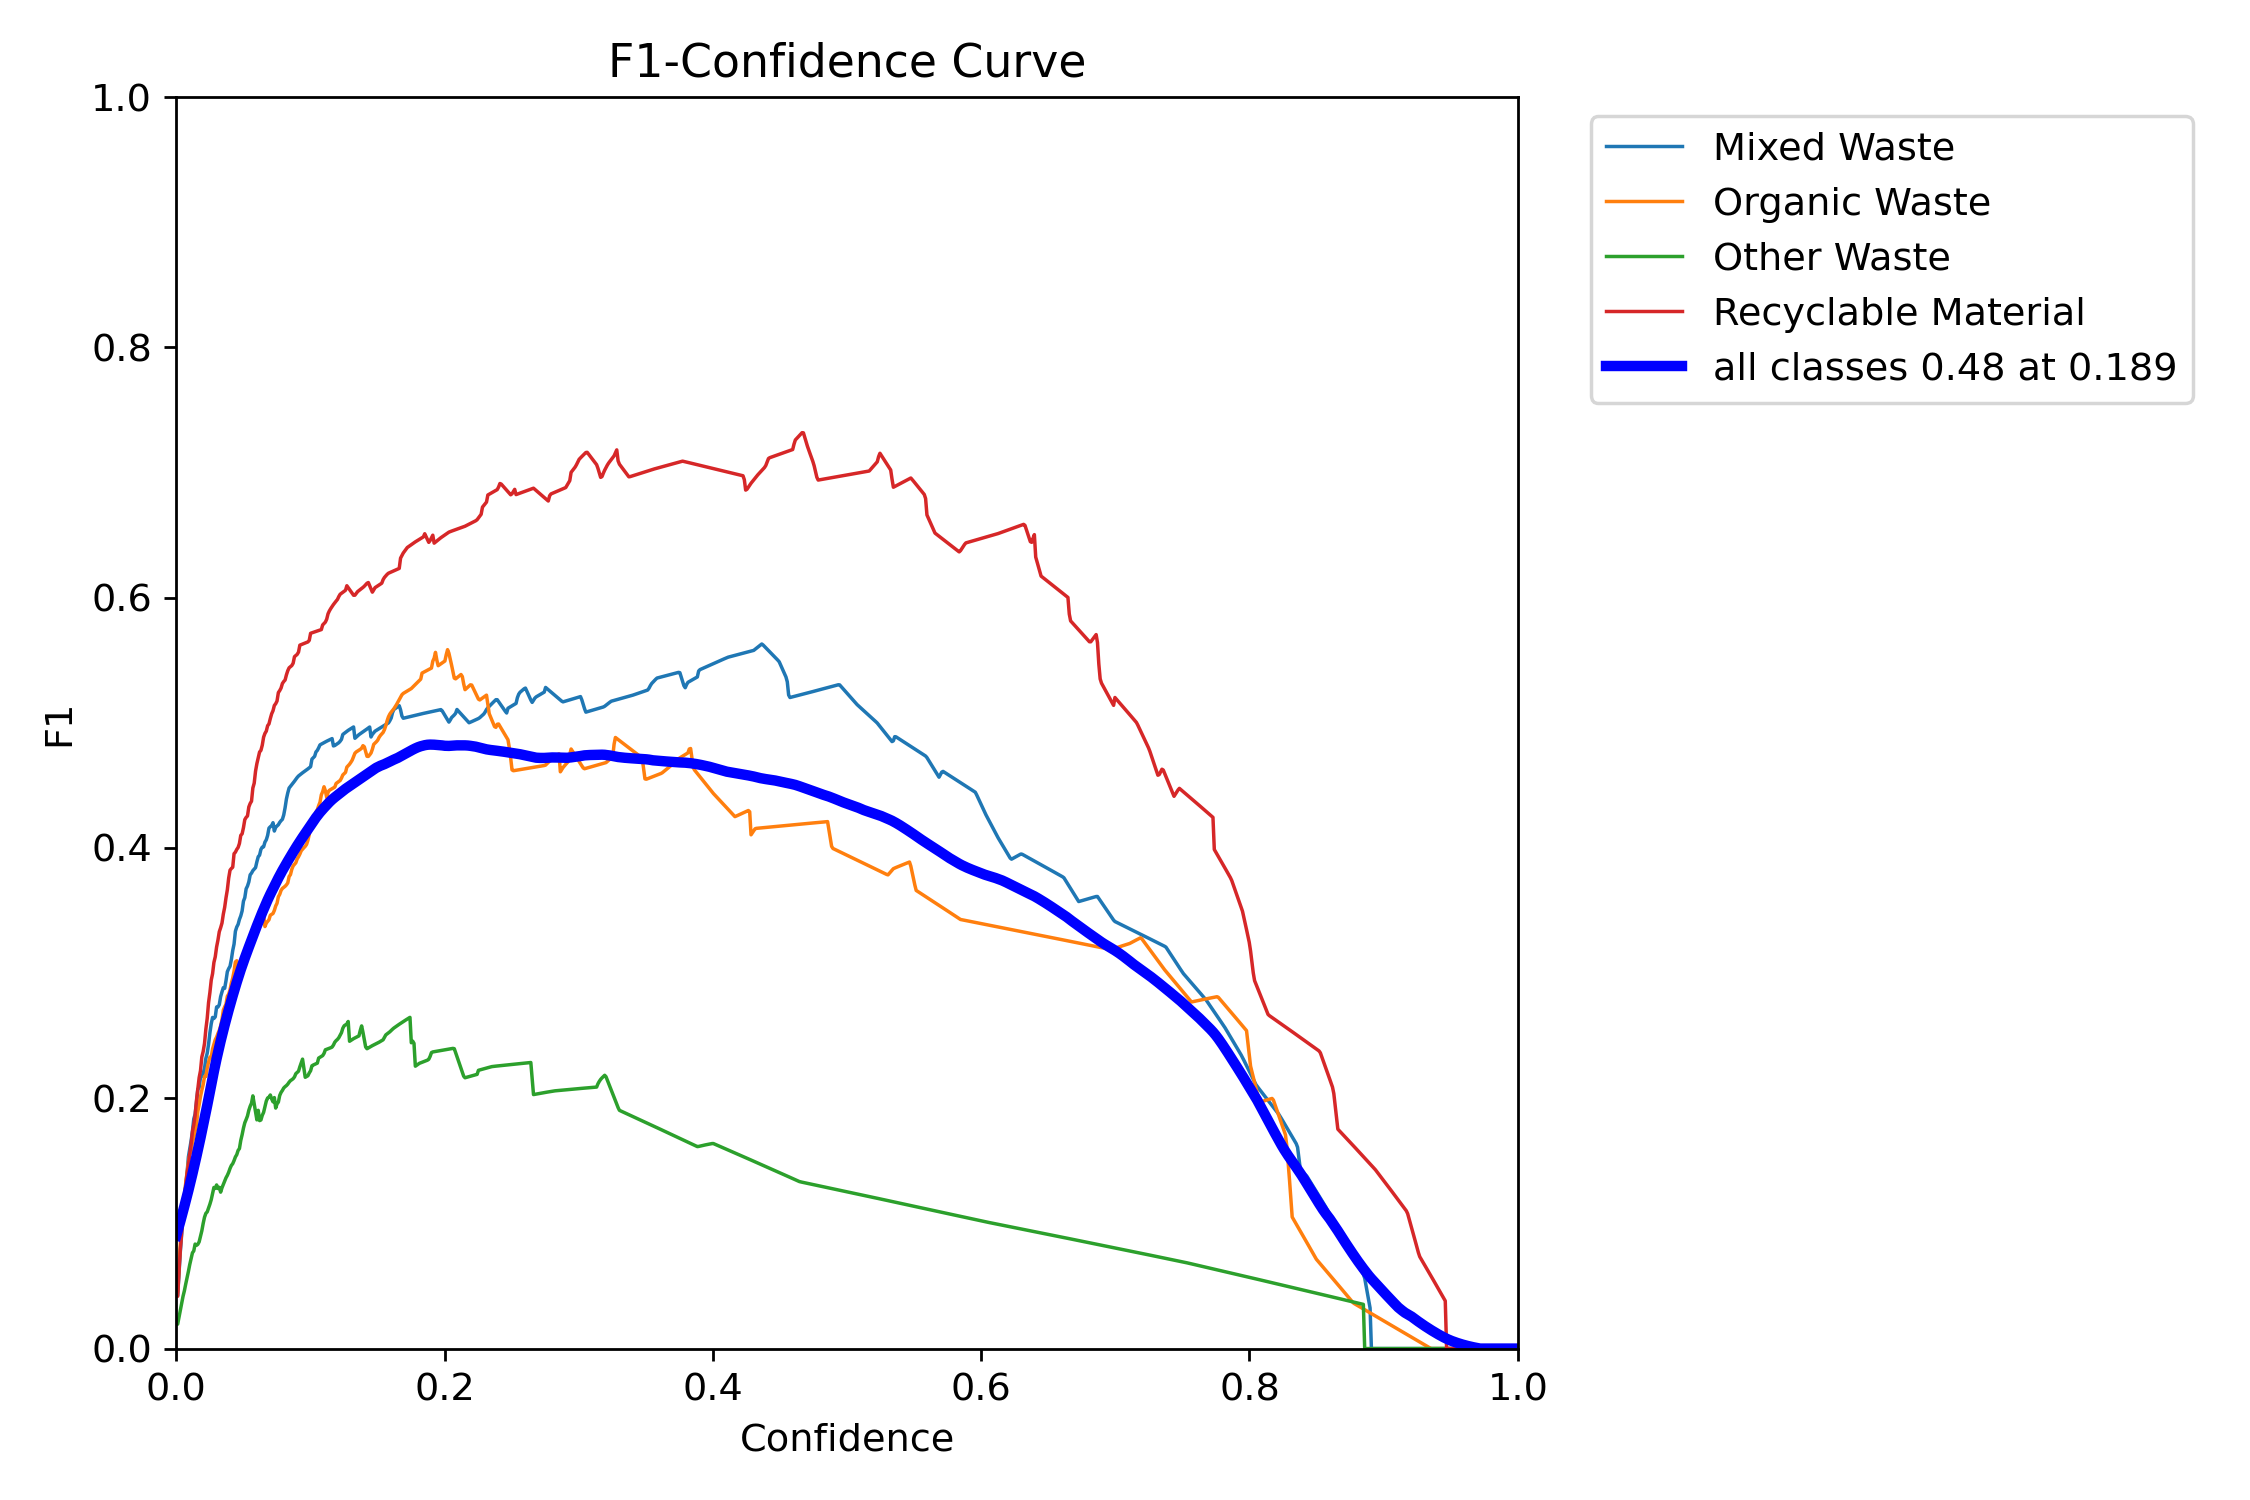

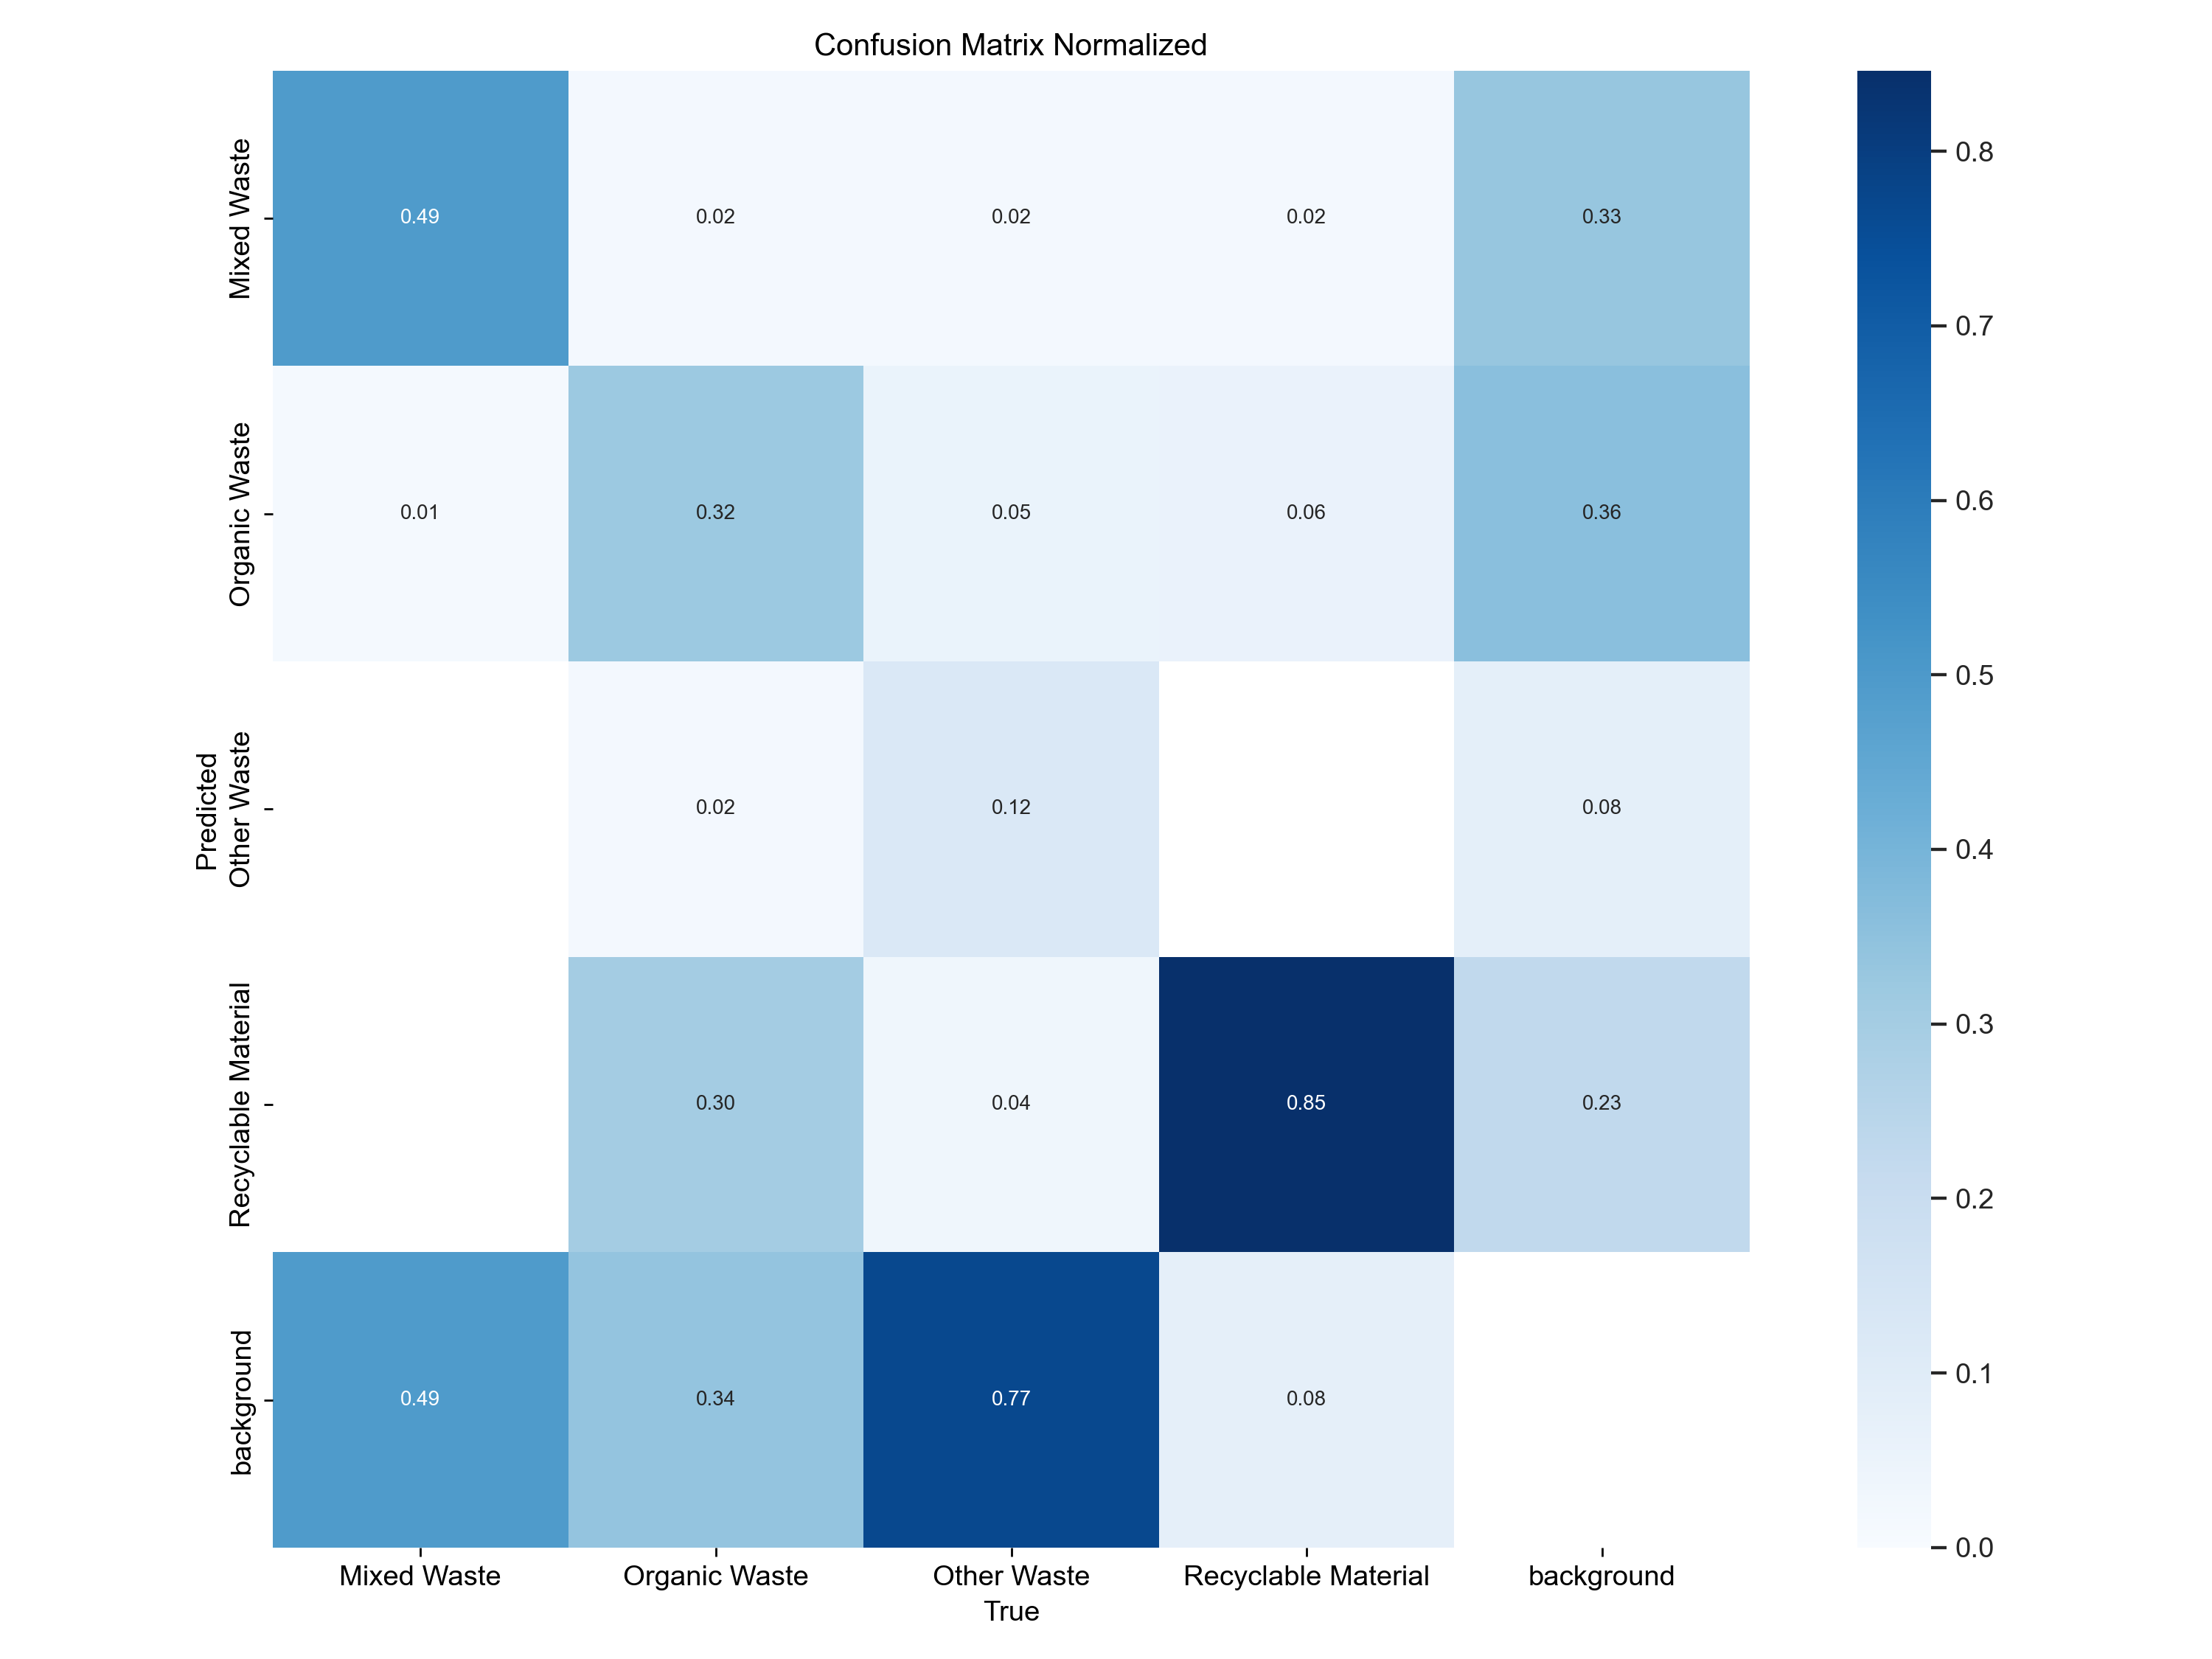

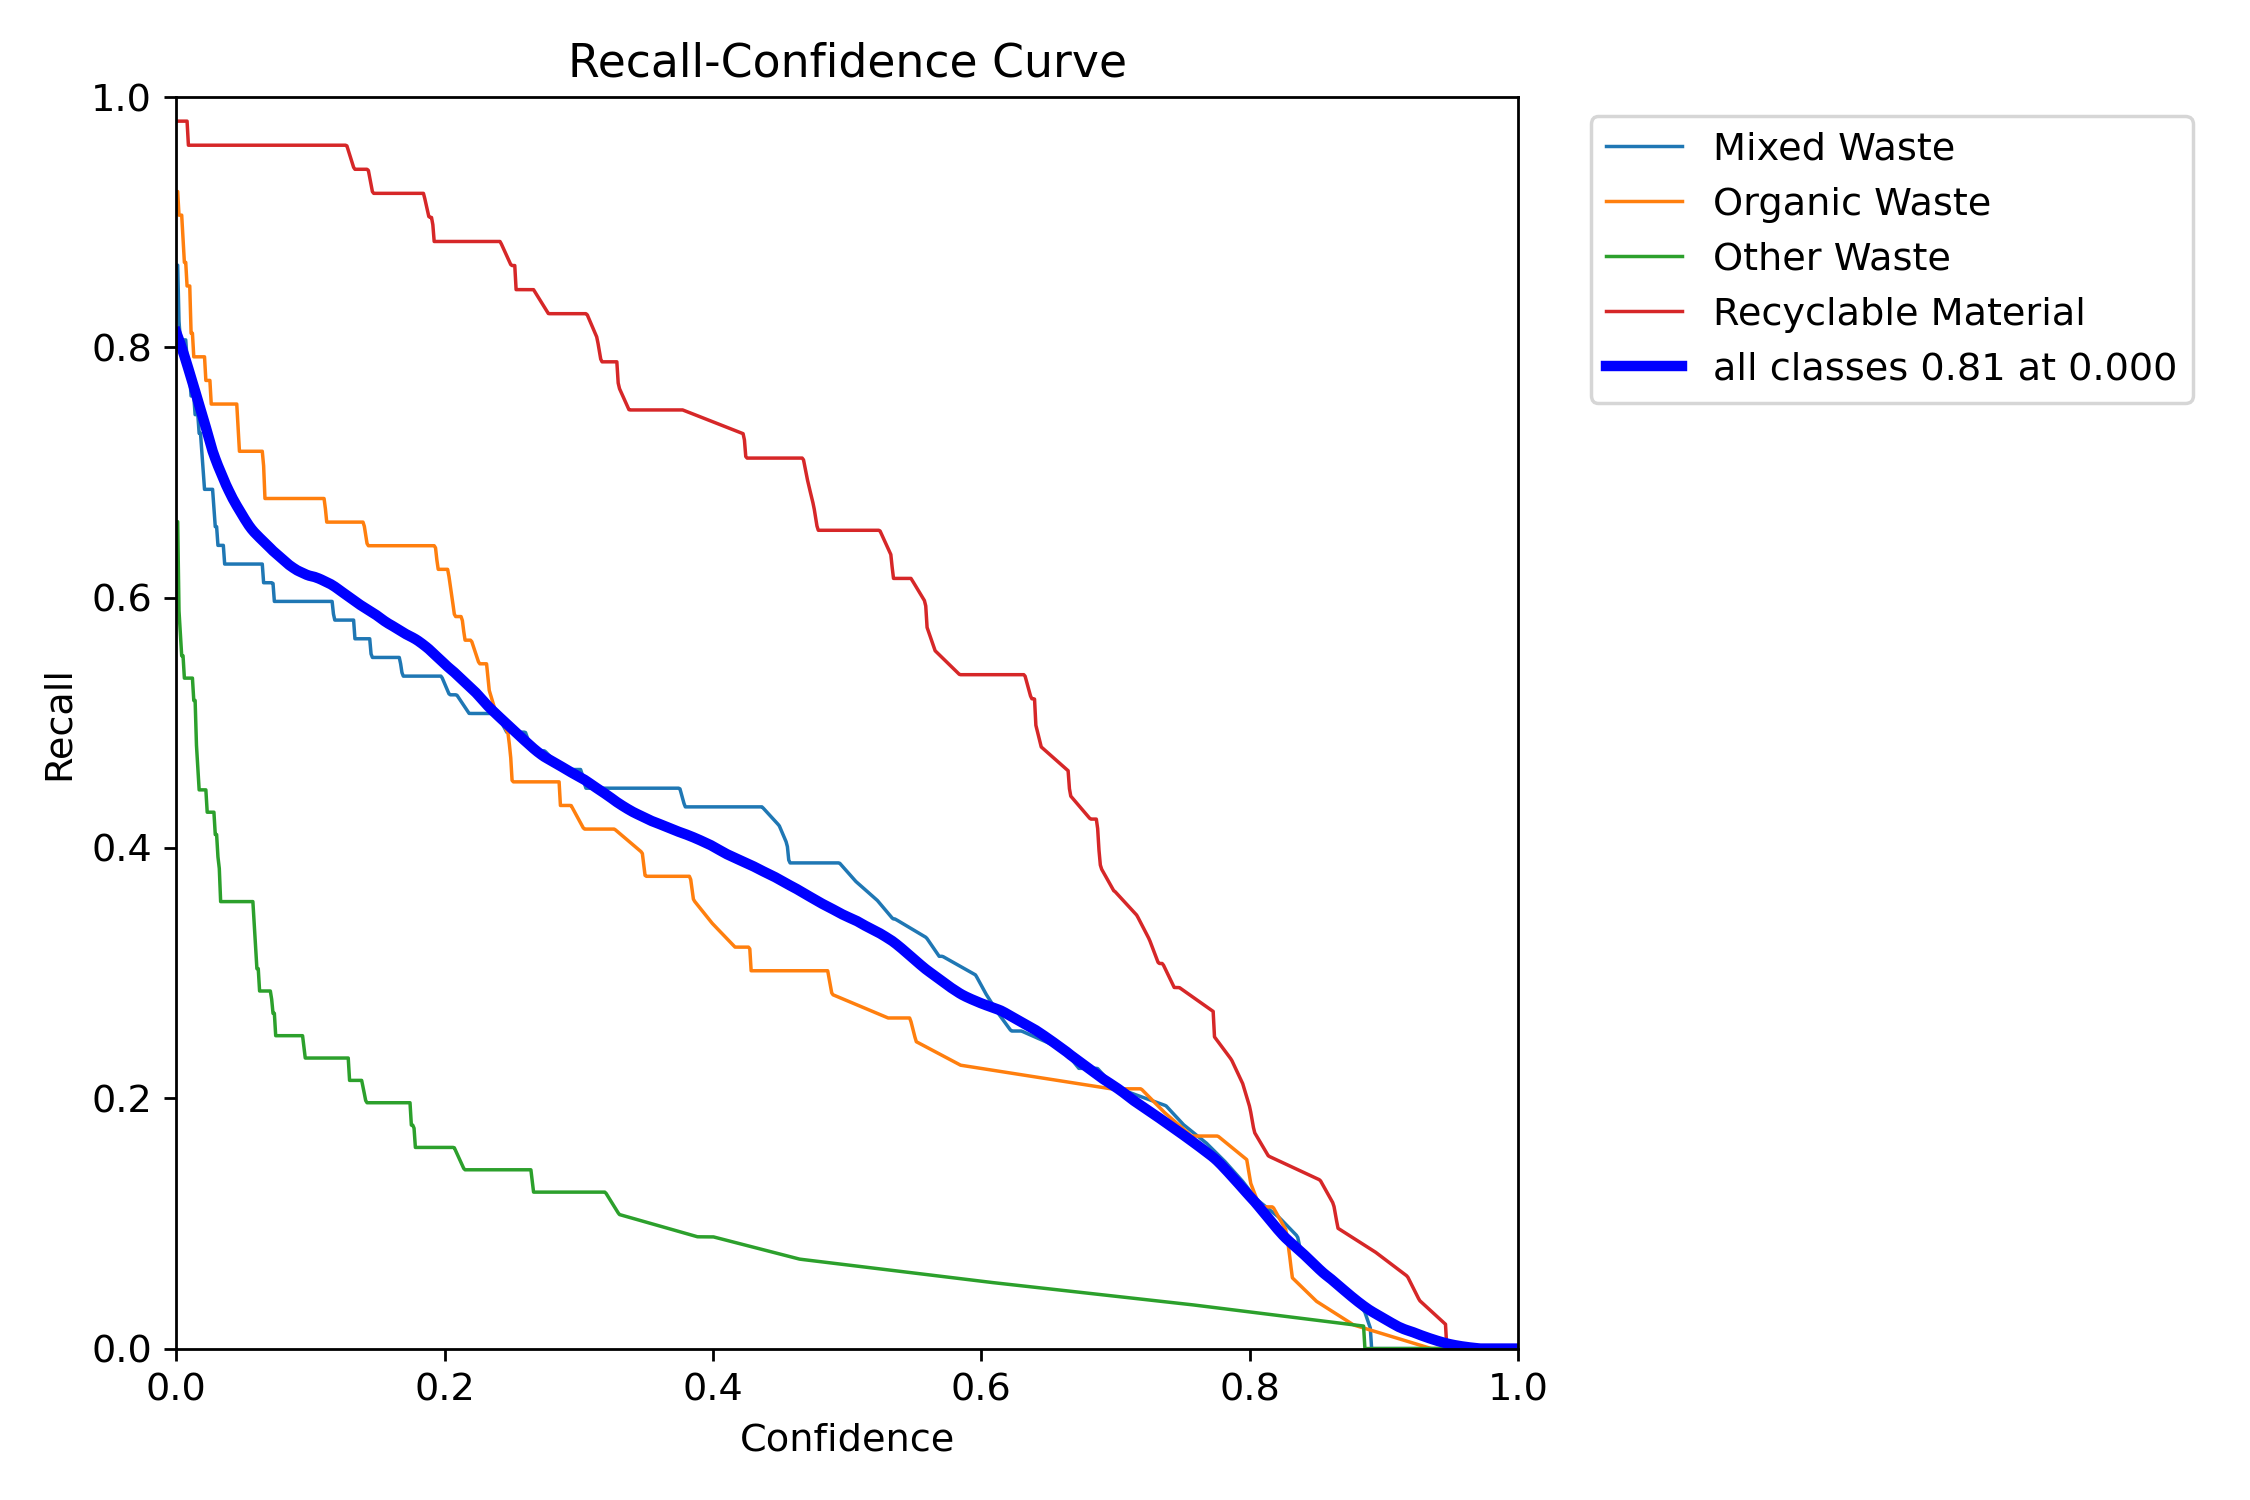

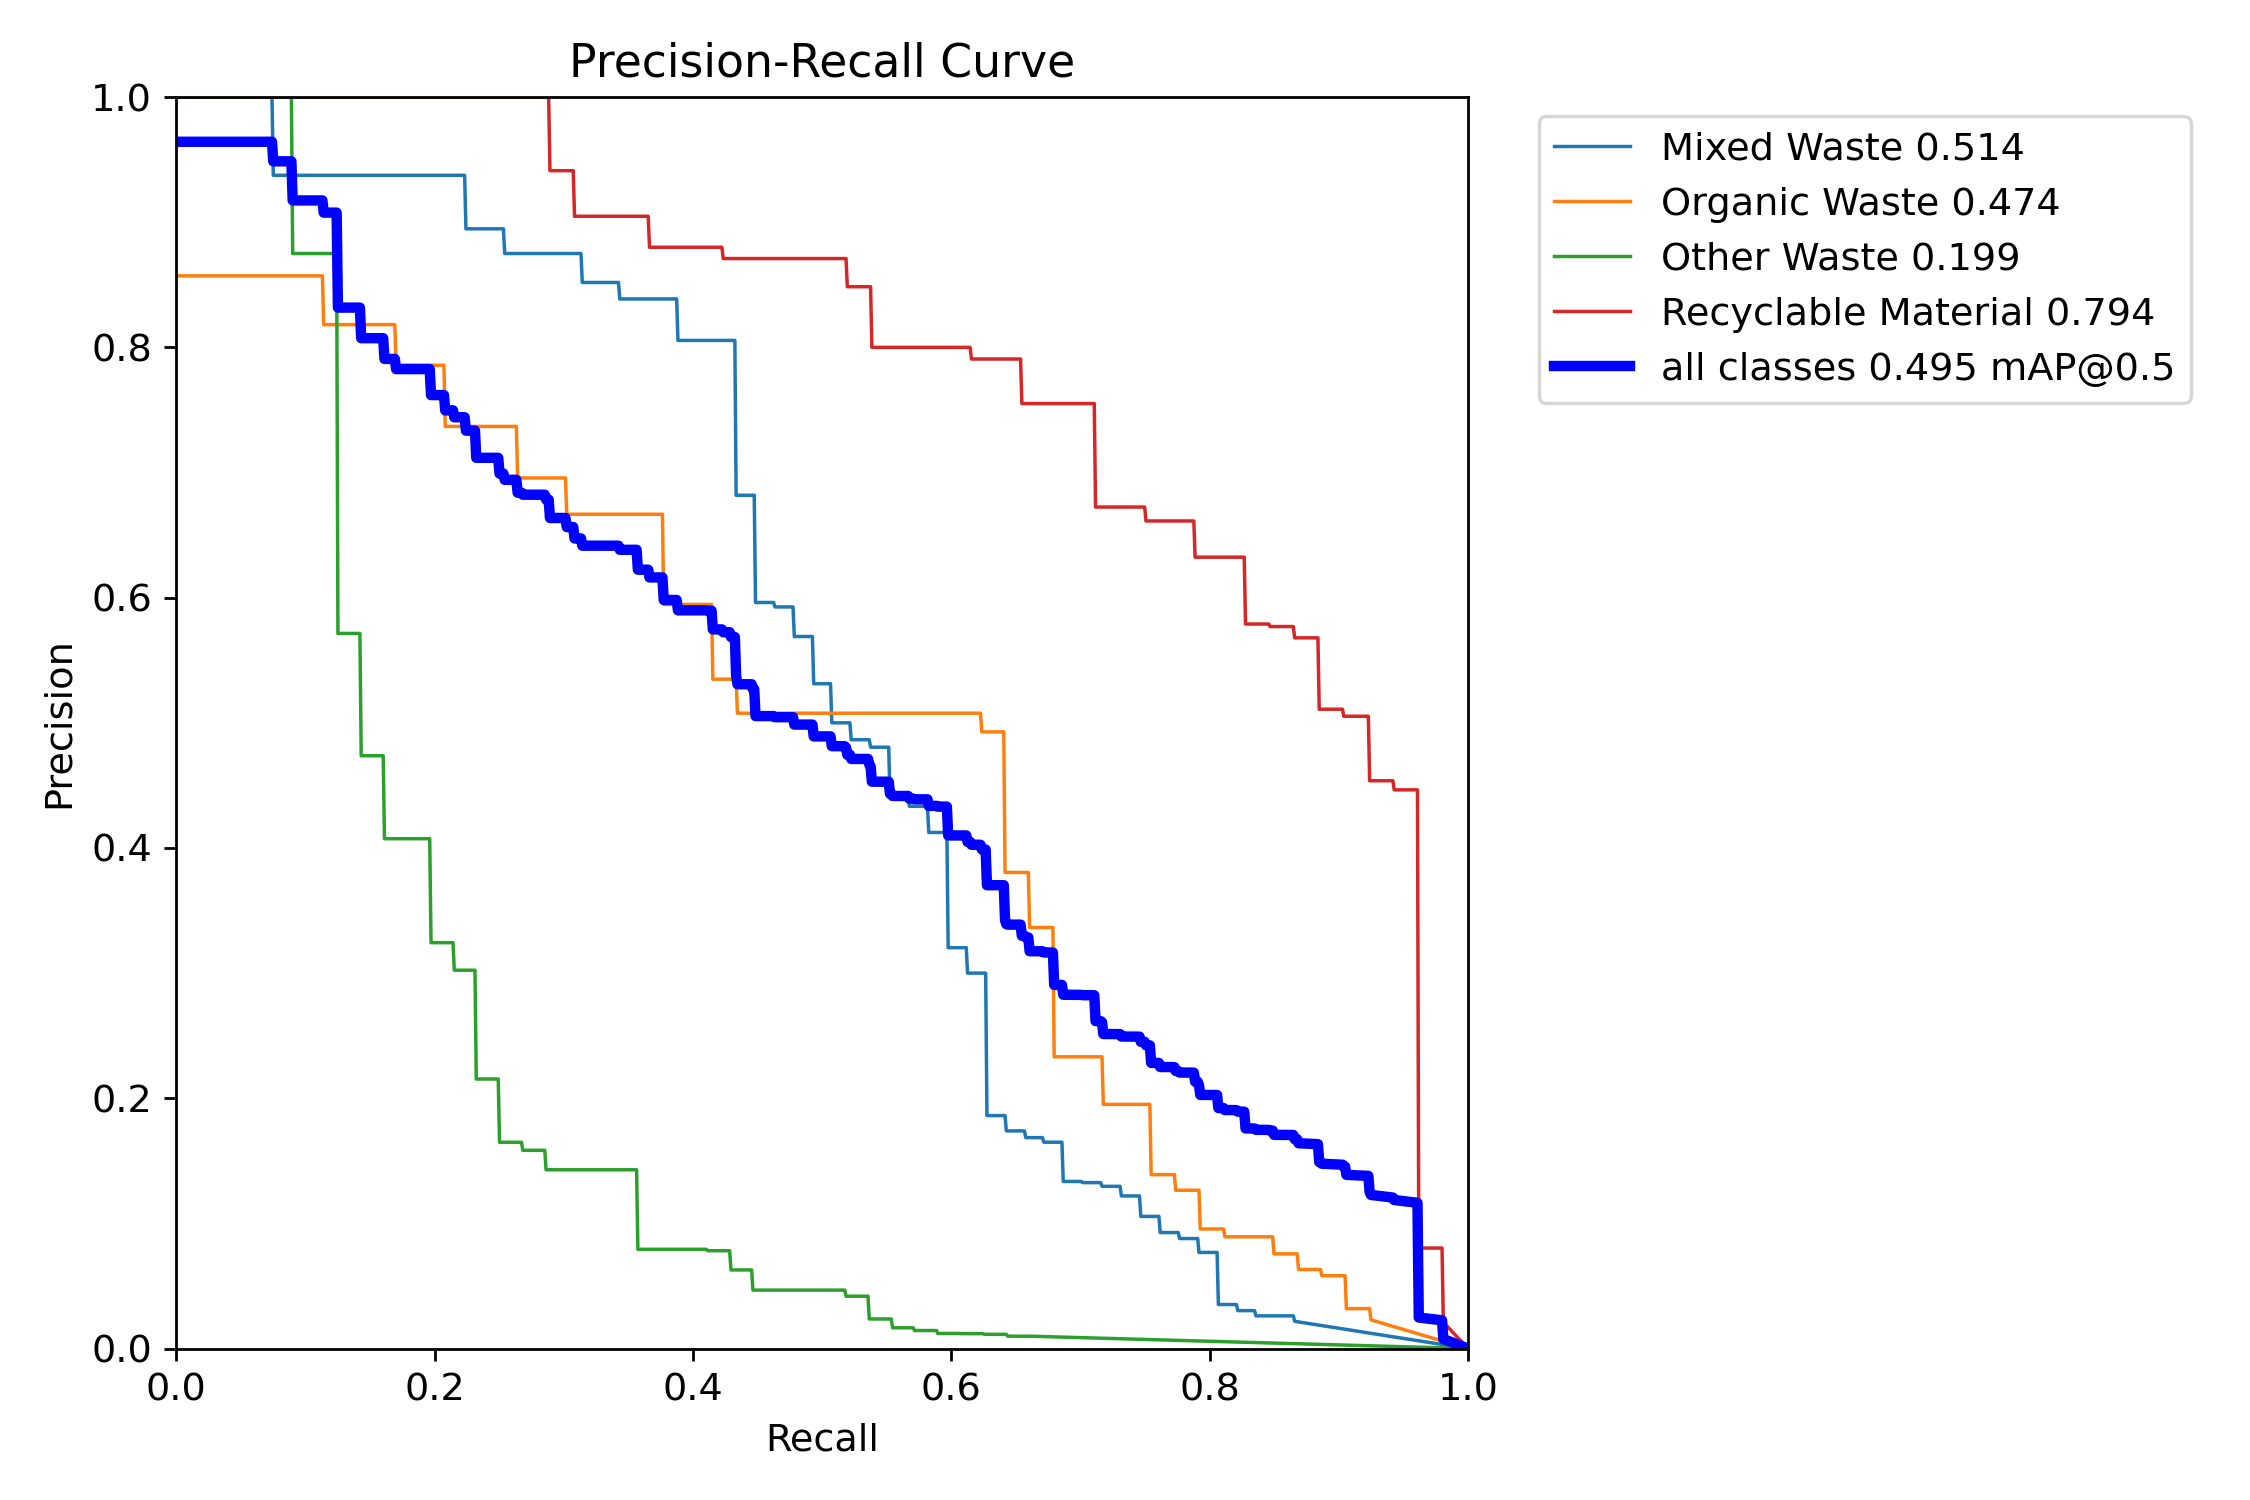

In [8]:
# Path to the "runs/detect" folder
detect_folder_path = os.path.join(os.getcwd(), "runs", "detect")

# Get all folders ending with "R"
folders_ending_with_R = [
    folder for folder in os.listdir(detect_folder_path)
    if folder.endswith("R") and os.path.isdir(os.path.join(detect_folder_path, folder))
]

# Check if there are any folders to choose from
if not folders_ending_with_R:
    print("No Results folders found!")
else:
    # Display available folders for user selection
    print("Available folders:")
    for i, folder in enumerate(folders_ending_with_R, start=1):
        print(f"{i}. {folder}")
    
    # Prompt the user to select a folder
    try:
        choice = int(input("Enter the number corresponding to the folder you want to use: "))
        selected_folder = folders_ending_with_R[choice - 1]
    except (ValueError, IndexError):
        print("Invalid selection. Please restart and try again.")
        raise

    # Path to the selected folder
    eval_folder_path = os.path.join(detect_folder_path, selected_folder)

    # List of evaluation images excluding "val_batch" files
    evaluation_images = [
        img for img in os.listdir(eval_folder_path)
        if img.lower().endswith(('.png', '.jpg')) and "val_batch" not in img
    ]

    # Display images
    if not evaluation_images:
        print("No evaluation images found in the selected folder.")
    else:
        for img_file in evaluation_images:
            img_path = os.path.join(eval_folder_path, img_file)
            display(Image(filename=img_path))

In [ ]:
# DOES NOT WORK
def calculate_iou(box1, box2):
    # Calculate intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate union
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area_box1 + area_box2 - intersection

    return intersection / union if union > 0 else 0


def compute_map_iou(val_results, iou_threshold=0.5):
    predictions = val_results['pred']  # Predicted bounding boxes
    ground_truths = val_results['labels']  # Ground truth bounding boxes

    true_positives = []
    false_positives = []
    iou_scores = []

    # Iterate through predictions and ground truths
    for pred, gt in zip(predictions, ground_truths):
        for p_box in pred:
            p_bbox, p_class, p_conf = p_box[:4], int(p_box[5]), p_box[4]

            best_iou = 0
            best_gt_idx = -1
            for idx, g_box in enumerate(gt):
                g_bbox, g_class = g_box[:4], int(g_box[4])
                iou = calculate_iou(p_bbox, g_bbox)

                if iou > best_iou and g_class == p_class:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou >= iou_threshold and best_gt_idx != -1:
                true_positives.append(1)
                iou_scores.append(best_iou)
                gt.pop(best_gt_idx)  # Remove matched ground truth
            else:
                false_positives.append(1)

    # Calculate mAP
    tp_cumsum = np.cumsum(true_positives)
    fp_cumsum = np.cumsum(false_positives)
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum)
    recalls = tp_cumsum / len(ground_truths)

    # Integrate precision-recall curve for AP
    mAP = np.trapz(precisions, recalls) if len(precisions) > 0 else 0.0

    # Calculate mean IoU
    mean_iou = np.mean(iou_scores) if iou_scores else 0.0

    return {"mAP": mAP, "mean_IoU": mean_iou}


try:
    val_results = model.val()

    # Compute mAP and IoU from YOLO validation results
    metrics = compute_map_iou(val_results)
    print("\n=== Code-Based Metrics ===")
    print(f"mAP: {metrics['mAP']:.4f}")
    print(f"Mean IoU: {metrics['mean_IoU']:.4f}")

except Exception as e:
    print(f"Error calculating metrics: {e}")
    raise

In [28]:
# Load the model
def load_model(weights_path):
    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Weights file not found at {weights_path}.")
    return YOLO(weights_path)

# Load the image
def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found at {image_path}.")
    image = cv2.imread(image_path)  # Load image in BGR format
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Ensure images are in RGB format
def ensure_rgb(image):
    if len(image.shape) == 3 and image.shape[2] == 3:  # Check if the image has 3 channels
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if not np.array_equal(
            image, cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2RGB)
        ) else image
    elif len(image.shape) == 2:  # Grayscale image
        return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB
    else:
        raise ValueError("Unsupported image format. Image must have 1 (grayscale) or 3 (RGB/BGR) channels.")

# Display images (side by side view for comparison)
def display_images_side_by_side(original, predicted, titles=("Original Test Image", "Predicted Image with Bounding Boxes")):
    # Ensure both images are in RGB format
    original_rgb = ensure_rgb(original)
    predicted_rgb = ensure_rgb(predicted)

    # Display images side by side
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_rgb)
    plt.title(titles[0])
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_rgb)
    plt.title(titles[1])
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [59]:
def analyze_detections(results, model):
    # Get detected boxes and classes
    boxes = results[0].boxes  # Bounding box tensor
    num_objects = len(boxes)  # Total number of detected objects

    if num_objects == 0:
        print("No (0) objects detected in the image.")
        return

    # Extract class IDs and confidence scores
    class_ids = boxes.cls.cpu().numpy()
    confidences = boxes.conf.cpu().numpy()

    # Map class IDs to class names using model's class names
    class_names = [model.names[int(cls_id)] for cls_id in class_ids]

    # Define fixed classes (ensure consistency in bar chart even if some classes are missing)
    fixed_classes = ["Mixed Waste", "Organic Waste", "Other Waste", "Recyclable Material"]
    class_counts = {class_name: 0 for class_name in fixed_classes}
    for class_name in class_names:
        if class_name in class_counts:
            class_counts[class_name] += 1

    # Display analytics
    print("\n=== Image Analytics ===")
    print(f"Total Objects Detected: {num_objects}")
    print("Object Breakdown:")
    for class_name, count in class_counts.items():
        print(f"  - {class_name}: {count}")
    print("Confidence Scores:")
    for i, (class_name, confidence) in enumerate(zip(class_names, confidences)):
        print(f"  {i + 1}. {class_name} - Confidence: {confidence:.2f}")

    # Plot bar chart for class counts
    colors = {
        "Mixed Waste": "lightcoral",  # Pastel red
        "Organic Waste": "lightgreen",  # Pastel green
        "Other Waste": "sandybrown",  # Pastel orange
        "Recyclable Material": "lightskyblue"  # Pastel blue
    }
    
    plt.figure(figsize=(8, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color=[colors[class_name] for class_name in class_counts.keys()])
    plt.title('Object Count per Class')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.yticks(range(0, max(class_counts.values()) + 2, 1))  # Ensure y-axis increments by 1
    plt.show()

    # Scatter plot for confidence scores
    plt.figure(figsize=(10, 6))
    scatter_colors = [colors[class_name] for class_name in class_names]
    plt.scatter(class_names, confidences, c=scatter_colors, alpha=0.7, edgecolor='k')
    plt.title('Confidence Scores by Class')
    plt.xlabel('Classes')
    plt.ylabel('Confidence Scores')
    plt.ylim(0, 1.05)  # Confidence scores range from 0 to 1
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Selected test image: /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Test/AFL_T4N.png
Using MPS (Metal Performance Shaders) for acceleration.

image 1/1 /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Test/AFL_T4N.png: 416x640 2 Mixed Wastes, 1 Organic Waste, 2 Other Wastes, 52.2ms
Speed: 2.7ms preprocess, 52.2ms inference, 80.8ms postprocess per image at shape (1, 3, 416, 640)


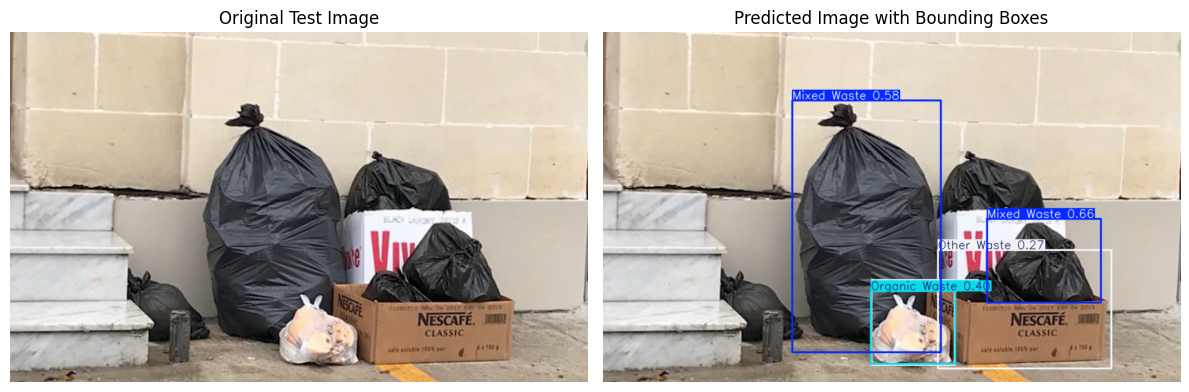


=== Image Analytics ===
Total Objects Detected: 5
Object Breakdown:
  - Mixed Waste: 2
  - Organic Waste: 1
  - Other Waste: 2
  - Recyclable Material: 0
Confidence Scores:
  1. Mixed Waste - Confidence: 0.66
  2. Mixed Waste - Confidence: 0.58
  3. Organic Waste - Confidence: 0.40
  4. Other Waste - Confidence: 0.29
  5. Other Waste - Confidence: 0.27


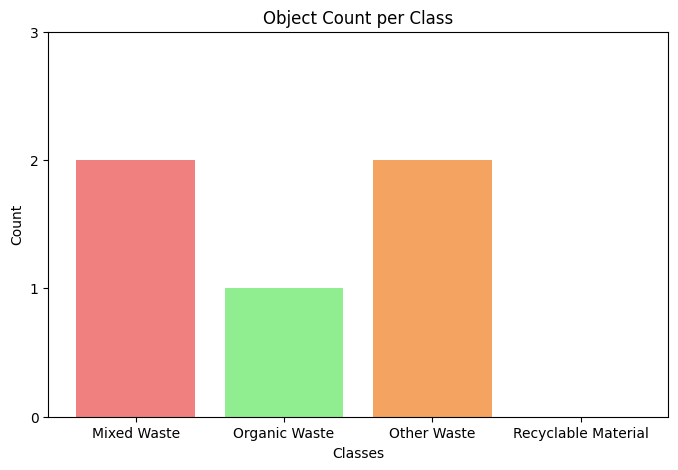

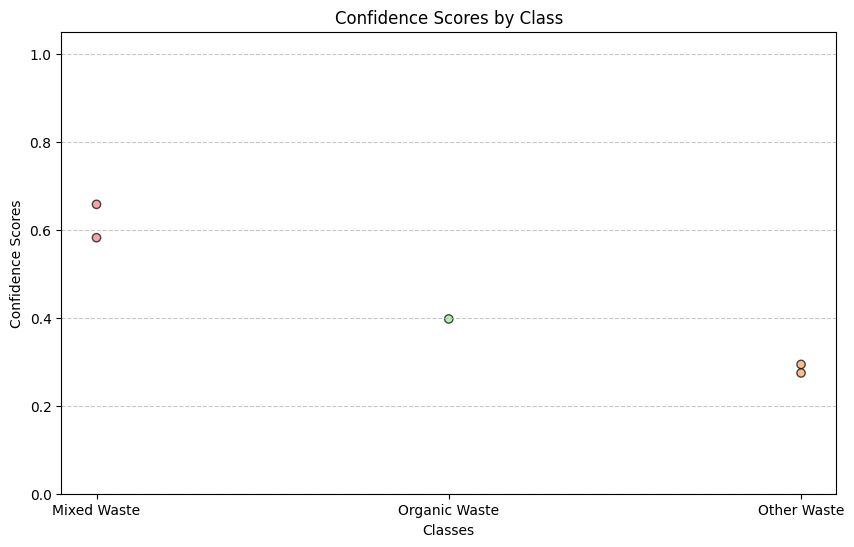

In [78]:
# Paths
weights_path = os.path.join(os.getcwd(), "runs", "detect", "MDD-AFL-Yolov8_v2", "weights", "best.pt")
test_folder_path = os.path.abspath(os.path.join(os.getcwd(), "..", "Test"))

# Validate and select a random test image
if not os.path.exists(test_folder_path):
    raise FileNotFoundError(f"Test folder not found at: {test_folder_path}")

test_images = [img for img in os.listdir(test_folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
if not test_images:
    raise ValueError(f"No valid image files found in the test folder: {test_folder_path}")

test_image_path = os.path.join(test_folder_path, random.choice(test_images))
print(f"Selected test image: {test_image_path}")

# Determine the device
device = determine_device()  # Ensure this function is defined elsewhere in your code

# Load the YOLO model
model = load_model(weights_path)

# Ensure plots are displayed inline
%matplotlib inline

# Perform prediction on the selected test image
results = model.predict(source=test_image_path, device=device)

# Load and process the images
original_image = load_image(test_image_path)  # Ensure this loads the image in RGB
predicted_image = cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB)  # Convert rendered image to RGB

# Display the original and predicted images side by side
display_images_side_by_side(original_image, predicted_image)

# Analyze and display detection analytics
analyze_detections(results, model)